<a href="https://colab.research.google.com/github/thunderhoser/ml_for_national_blend/blob/main/spatial_clustering_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook shows how to implement my spatial clustering, along with the motivation for said clustering (regional bias correction) and an explanation of the parameters for the clustering algorithm.

-- Ryan Lagerquist

# <font color='red'>Download/install Python libraries (required)</font>

The next code cell downloads and installs the Python library `ml_for_national_blend`, along with all dependencies of `ml_for_national_blend`.  After running this code cell, you will need to <font color='red'>restart the runtime</font>, by clicking on "Runtime" and then "Restart session" at the top of the screen.  After restarting the runtime, <font color='red'>do not run this code cell again!</font>

In [ ]:
!git clone https://github.com/thunderhoser/ml_for_national_blend ml4nbm_repo
!cd ml4nbm_repo; python setup.py install

Cloning into 'ml4nbm_repo'...
remote: Enumerating objects: 9038, done.
remote: Counting objects: 100% (398/398), done.
remote: Compressing objects: 100% (280/280), done.
remote: Total 9038 (delta 294), reused 208 (delta 118), pack-reused 8640 (from 2)
Receiving objects: 100% (9038/9038), 242.49 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (7266/7266), done.
Updating files: 100% (142/142), done.
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/u

# <font color='red'>Import packages (required)</font>

The next code cell imports all packages used in this notebook.

In [ ]:
%matplotlib inline
import numpy
import xarray
import matplotlib.colors
from matplotlib import pyplot
from ml_for_national_blend.io import border_io
from ml_for_national_blend.io import nbm_constant_io
from ml_for_national_blend.utils import bias_clustering
from ml_for_national_blend.utils import nbm_constant_utils
from ml_for_national_blend.outside_code import number_rounding
from ml_for_national_blend.outside_code import \
    longitude_conversion as lng_conversion
from ml_for_national_blend.plotting import plotting_utils
from ml_for_national_blend.plotting import target_plotting

# <font color='red'>Define constants (required)</font>

The next code cell defines all constants used in this notebook.

In [ ]:
FIGURE_WIDTH_INCHES = 10
FIGURE_HEIGHT_INCHES = 10

NAN_COLOUR = numpy.full(3, 152. / 255)
OUT_OF_CLUSTER_COLOUR = numpy.full(3, 1.)
IN_CLUSTER_COLOUR = numpy.array([217, 95, 2], dtype=float) / 255

COLORADO_LATITUDE_LIMITS_DEG_N = numpy.array([37, 41], dtype=float)
COLORADO_LONGITUDE_LIMITS_DEG_E = numpy.array([-109, -100], dtype=float)

COLORADO_LONGITUDE_LIMITS_DEG_E = lng_conversion.convert_lng_positive_in_west(
    COLORADO_LONGITUDE_LIMITS_DEG_E
)

BIAS_HISTOGRAM_COLOUR = numpy.array([27, 158, 119], dtype=float) / 255
ELEVATION_HISTOGRAM_COLOUR = numpy.array([117, 112, 179], dtype=float) / 255

DEFAULT_FONT_SIZE = 22
pyplot.rc('font', size=DEFAULT_FONT_SIZE)
pyplot.rc('axes', titlesize=DEFAULT_FONT_SIZE)
pyplot.rc('axes', labelsize=DEFAULT_FONT_SIZE)
pyplot.rc('xtick', labelsize=DEFAULT_FONT_SIZE)
pyplot.rc('ytick', labelsize=DEFAULT_FONT_SIZE)
pyplot.rc('legend', fontsize=DEFAULT_FONT_SIZE)
pyplot.rc('figure', titlesize=DEFAULT_FONT_SIZE)

# <font color='red'>Define helpful plotting methods (required)</font>

The next code cell defines two plotting methods: one that plots all spatial clusters in a given solution and one that plots a single cluster in a given solution.

In [ ]:
def plot_all_clusters(
        cluster_id_matrix, grid_latitude_matrix_deg_n,
        grid_longitude_matrix_deg_e, border_latitudes_deg_n,
        border_longitudes_deg_e):
    """Plots all spatial clusters in a given solution.

    M = number of rows in NBM grid
    N = number of columns in NBM grid
    P = number of vertices in border file

    :param cluster_id_matrix: M-by-N numpy array of integer cluster IDs.
    :param grid_latitude_matrix_deg_n: M-by-N numpy array of latitudes (deg
        north).
    :param grid_longitude_matrix_deg_e: M-by-N numpy array of eastitudes (deg
        east).
    :param border_latitudes_deg_n: length-P numpy array with latitudes (deg
        north) of political borders.
    :param border_longitudes_deg_e: length-P numpy array with longitudes (deg
        east) of political borders.
    """

    unique_cluster_ids = numpy.unique(cluster_id_matrix)
    random_colours = numpy.random.rand(len(unique_cluster_ids), 3)
    colour_map_object = matplotlib.colors.ListedColormap(random_colours)
    colour_norm_object = matplotlib.colors.Normalize(
        vmin=numpy.min(cluster_id_matrix),
        vmax=numpy.max(cluster_id_matrix)
    )

    figure_object, axes_object = pyplot.subplots(
        1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )
    target_plotting.plot_field(
        data_matrix=cluster_id_matrix,
        latitude_matrix_deg_n=grid_latitude_matrix_deg_n,
        longitude_matrix_deg_e=grid_longitude_matrix_deg_e,
        colour_map_object=colour_map_object,
        colour_norm_object=colour_norm_object,
        axes_object=axes_object,
        plot_colour_bar=False
    )

    plotting_utils.plot_borders(
        border_latitudes_deg_n=border_latitudes_deg_n,
        border_longitudes_deg_e=border_longitudes_deg_e,
        axes_object=axes_object,
        line_colour=numpy.full(3, 0.)
    )
    plotting_utils.plot_grid_lines(
        plot_latitudes_deg_n=numpy.ravel(grid_latitude_matrix_deg_n),
        plot_longitudes_deg_e=numpy.ravel(grid_longitude_matrix_deg_e),
        axes_object=axes_object,
        meridian_spacing_deg=20.,
        parallel_spacing_deg=10.
    )

    axes_object.set_xlim(
        numpy.min(grid_longitude_matrix_deg_e),
        numpy.max(grid_longitude_matrix_deg_e)
    )
    axes_object.set_ylim(
        numpy.min(grid_latitude_matrix_deg_n),
        numpy.max(grid_latitude_matrix_deg_n)
    )

    axes_object.set_title('All clusters (plotted with random colours)')
    pyplot.show()


def plot_one_cluster(
        cluster_id_matrix, desired_cluster_id, grid_latitude_matrix_deg_n,
        grid_longitude_matrix_deg_e, border_latitudes_deg_n,
        border_longitudes_deg_e):
    """Plots one spatial cluster in a given solution.

    M = number of rows in NBM grid
    N = number of columns in NBM grid
    P = number of vertices in border file

    :param cluster_id_matrix: M-by-N numpy array of integer cluster IDs.
    :param desired_cluster_id: Cluster to plot (integer).
    :param grid_latitude_matrix_deg_n: M-by-N numpy array of latitudes (deg
        north).
    :param grid_longitude_matrix_deg_e: M-by-N numpy array of eastitudes (deg
        east).
    :param border_latitudes_deg_n: length-P numpy array with latitudes (deg
        north) of political borders.
    :param border_longitudes_deg_e: length-P numpy array with longitudes (deg
        east) of political borders.
    """

    colour_list = numpy.vstack([OUT_OF_CLUSTER_COLOUR, IN_CLUSTER_COLOUR])
    colour_map_object = matplotlib.colors.ListedColormap(colour_list)
    colour_norm_object = matplotlib.colors.Normalize(vmin=0.2, vmax=0.8)

    figure_object, axes_object = pyplot.subplots(
        1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )
    target_plotting.plot_field(
        data_matrix=(cluster_id_matrix == desired_cluster_id).astype(float),
        latitude_matrix_deg_n=grid_latitude_matrix_deg_n,
        longitude_matrix_deg_e=grid_longitude_matrix_deg_e,
        colour_map_object=colour_map_object,
        colour_norm_object=colour_norm_object,
        axes_object=axes_object,
        plot_colour_bar=False
    )

    plotting_utils.plot_borders(
        border_latitudes_deg_n=border_latitudes_deg_n,
        border_longitudes_deg_e=border_longitudes_deg_e,
        axes_object=axes_object,
        line_colour=numpy.full(3, 0.)
    )
    plotting_utils.plot_grid_lines(
        plot_latitudes_deg_n=numpy.ravel(grid_latitude_matrix_deg_n),
        plot_longitudes_deg_e=numpy.ravel(grid_longitude_matrix_deg_e),
        axes_object=axes_object,
        meridian_spacing_deg=20.,
        parallel_spacing_deg=10.
    )

    axes_object.set_xlim(
        COLORADO_LONGITUDE_LIMITS_DEG_E[0] - 3.,
        COLORADO_LONGITUDE_LIMITS_DEG_E[1] + 3.
    )
    axes_object.set_ylim(
        COLORADO_LATITUDE_LIMITS_DEG_N[0] - 3.,
        COLORADO_LATITUDE_LIMITS_DEG_N[1] + 3.
    )

    axes_object.set_title('Cluster {0:d}'.format(desired_cluster_id))
    pyplot.show()

# <font color='red'>Define another plotting method (required)</font>

The next code cell defines a method for plotting two histograms on the same axes: temperature bias within a cluster and elevation within a cluster.

In [ ]:
def plot_histogram_one_cluster(
        cluster_id_matrix, desired_cluster_id, bias_matrix_kelvins,
        grid_elevation_matrix_m_asl):
    """Plots dual histogram (elevation and temperature bias) for one cluster.

    M = number of rows in NBM grid
    N = number of columns in NBM grid

    :param cluster_id_matrix: M-by-N numpy array of integer cluster IDs.
    :param desired_cluster_id: Cluster to plot (integer).
    :param bias_matrix_kelvins: M-by-N numpy array of temperature biases.
    :param grid_elevation_matrix_m_asl: M-by-N numpy array of elevations (metres
        above sea level).
    """

    flag_matrix = cluster_id_matrix == desired_cluster_id
    bias_vector_kelvins = bias_matrix_kelvins[flag_matrix]
    elevation_vector_m_asl = grid_elevation_matrix_m_asl[flag_matrix]

    real_indices = numpy.where(numpy.invert(numpy.logical_or(
        numpy.isnan(bias_vector_kelvins),
        numpy.isnan(elevation_vector_m_asl)
    )))[0]
    bias_vector_kelvins = bias_vector_kelvins[real_indices]
    elevation_vector_m_asl = elevation_vector_m_asl[real_indices]

    figure_object, axes_object_for_bias = pyplot.subplots(
        1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
    )

    first_bin_edge = number_rounding.floor_to_nearest(
        numpy.nanmin(bias_vector_kelvins), 0.05
    )
    last_bin_edge = number_rounding.ceiling_to_nearest(
        numpy.nanmax(bias_vector_kelvins), 0.05
    )
    num_bins = int(numpy.round(
        1 + (last_bin_edge - first_bin_edge) / 0.05
    ))
    bin_edges = numpy.linspace(
        first_bin_edge, last_bin_edge, num=num_bins, dtype=float
    )
    bias_counts, bias_bin_edges = numpy.histogram(
        bias_vector_kelvins, bins=bin_edges
    )

    first_bin_edge = number_rounding.floor_to_nearest(
        numpy.nanmin(elevation_vector_m_asl), 50.
    )
    last_bin_edge = number_rounding.ceiling_to_nearest(
        numpy.nanmax(elevation_vector_m_asl), 50.
    )
    num_bins = int(numpy.round(
        1 + (last_bin_edge - first_bin_edge) / 50.
    ))
    bin_edges = numpy.linspace(
        first_bin_edge, last_bin_edge, num=num_bins, dtype=float
    )
    elevation_counts, elevation_bin_edges = numpy.histogram(
        elevation_vector_m_asl, bins=bin_edges
    )

    axes_object_for_bias.bar(
        bias_bin_edges[:-1], -1 * bias_counts,
        width=numpy.diff(bias_bin_edges),
        color=BIAS_HISTOGRAM_COLOUR,
        edgecolor='black'
    )
    axes_object_for_bias.set_xlabel(
        'Temperature bias (K)', color=BIAS_HISTOGRAM_COLOUR
    )
    axes_object_for_bias.set_ylabel('Count')

    axes_object_for_elevation = axes_object_for_bias.twiny()
    axes_object_for_elevation.bar(
        elevation_bin_edges[:-1], elevation_counts,
        width=numpy.diff(elevation_bin_edges),
        color=ELEVATION_HISTOGRAM_COLOUR,
        edgecolor='black'
    )
    axes_object_for_elevation.set_xlabel(
        'Elevation (m ASL)', color=ELEVATION_HISTOGRAM_COLOUR
    )
    # axes_object_for_elevation.tick_params(
    #     axis='x', labelcolor=ELEVATION_HISTOGRAM_COLOUR
    # )

    mean_temp_bias_kelvins = numpy.mean(bias_vector_kelvins)
    mean_elevation_m_asl = numpy.mean(elevation_vector_m_asl)

    numerator = numpy.mean(
        (bias_vector_kelvins - mean_temp_bias_kelvins) *
        (elevation_vector_m_asl - mean_elevation_m_asl)
    )
    sum_squared_bias_diffs = numpy.mean(
        (bias_vector_kelvins - mean_temp_bias_kelvins) ** 2
    )
    sum_squared_elevation_diffs = numpy.mean(
        (elevation_vector_m_asl - mean_elevation_m_asl) ** 2
    )
    correlation = (
        numerator /
        numpy.sqrt(sum_squared_bias_diffs * sum_squared_elevation_diffs)
    )

    title_string = 'Cluster {0:d}; elevation/bias correlation = {1:.4f}'.format(
        desired_cluster_id, correlation
    )
    pyplot.title(title_string)

    pyplot.axhline(0, color='black', lw=0.8)
    pyplot.show()

# Motivation for spatial clustering (part 1)

The motivation for spatial clustering began with training neural networks.  Specifically, I had trained a neural network to forecast 2-m temperature at 48-h lead time.  The neural network produces an ensemble of forecasts at every grid point in the National Blend of Models (NBM) domain, which is 1597 $\times$ 2345 grid points.  While evaluating the neural network, I plotted several quantities as a function of grid point, including the bias of the neural network's deterministic forecast (*i.e.*, the mean of the ensemble produced by the network).  Recall that bias is the mean signed error, or the mean value of `predicted - actual`.  I ended up with the following bias map.

<font color='red'>Note: When you run the next code cell, an image (a map of temperature bias) should appear in the output.  If this doesn't happen, run the code cell again.</font>

Reading bias map from: "/content/ml4nbm_repo/ml_for_national_blend/utils/gridded_bias_example.nc"...


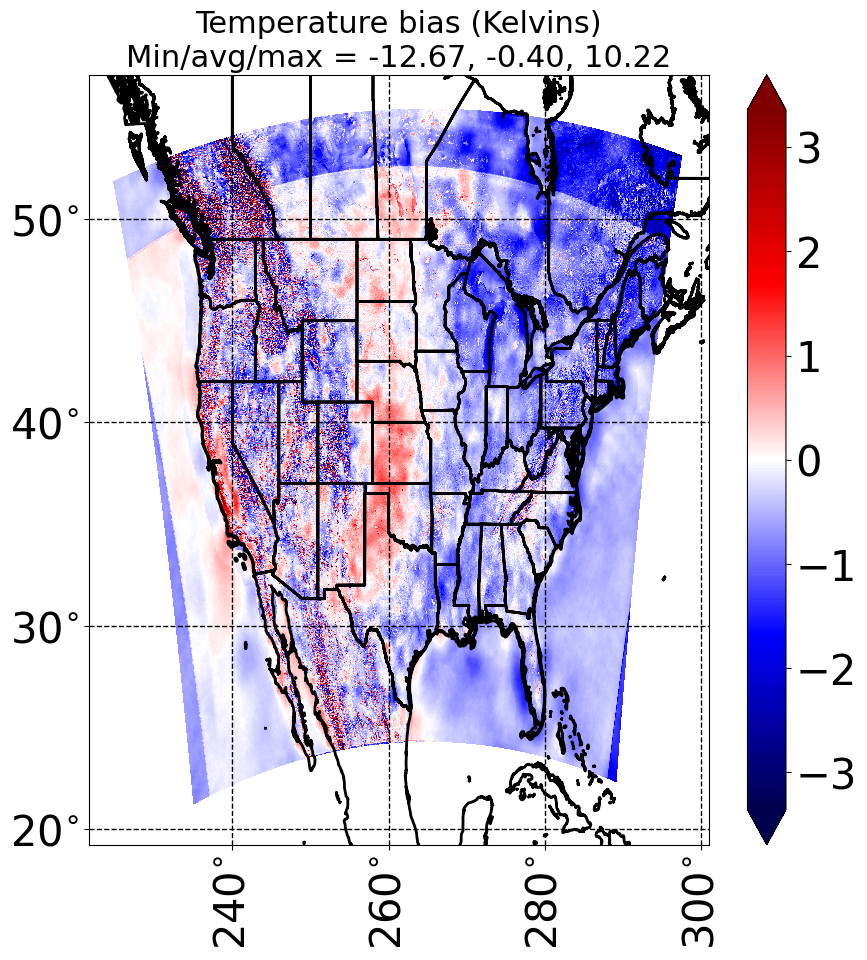

In [ ]:
%matplotlib inline

evaluation_file_name = (
    '/content/ml4nbm_repo/ml_for_national_blend/utils/gridded_bias_example.nc'
)

print('Reading bias map from: "{0:s}"...'.format(evaluation_file_name))
evaluation_table_xarray = xarray.open_dataset(evaluation_file_name)

bias_matrix_kelvins = evaluation_table_xarray['bias'].values[..., 0, 0]
grid_latitude_matrix_deg_n = evaluation_table_xarray['latitude_deg_n'].values
grid_longitude_matrix_deg_e = evaluation_table_xarray['longitude_deg_e'].values

max_colour_value = numpy.nanpercentile(
    numpy.absolute(bias_matrix_kelvins), 99.5
)
colour_map_object = pyplot.get_cmap('seismic')
colour_norm_object = pyplot.Normalize(
    vmin=-1 * max_colour_value, vmax=max_colour_value
)
colour_map_object.set_bad(NAN_COLOUR)

border_latitudes_deg_n, border_longitudes_deg_e = border_io.read_file()
border_longitudes_deg_e = lng_conversion.convert_lng_positive_in_west(
    border_longitudes_deg_e
)
grid_longitude_matrix_deg_e = lng_conversion.convert_lng_positive_in_west(
    grid_longitude_matrix_deg_e
)

figure_object, axes_object = pyplot.subplots(
    1, 1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES)
)

target_plotting.plot_field(
    data_matrix=bias_matrix_kelvins,
    latitude_matrix_deg_n=grid_latitude_matrix_deg_n,
    longitude_matrix_deg_e=grid_longitude_matrix_deg_e,
    colour_map_object=colour_map_object,
    colour_norm_object=colour_norm_object,
    axes_object=axes_object,
    plot_colour_bar=True
)

plotting_utils.plot_borders(
    border_latitudes_deg_n=border_latitudes_deg_n,
    border_longitudes_deg_e=border_longitudes_deg_e,
    axes_object=axes_object,
    line_colour=numpy.full(3, 0.)
)
plotting_utils.plot_grid_lines(
    plot_latitudes_deg_n=numpy.ravel(grid_latitude_matrix_deg_n),
    plot_longitudes_deg_e=numpy.ravel(grid_longitude_matrix_deg_e),
    axes_object=axes_object,
    meridian_spacing_deg=20.,
    parallel_spacing_deg=10.
)

axes_object.set_xlim(
    numpy.min(grid_longitude_matrix_deg_e),
    numpy.max(grid_longitude_matrix_deg_e)
)
axes_object.set_ylim(
    numpy.min(grid_latitude_matrix_deg_n),
    numpy.max(grid_latitude_matrix_deg_n)
)

title_string = (
    'Temperature bias (Kelvins)\nMin/avg/max = {0:.2f}, {1:.2f}, {2:.2f}'
).format(
    numpy.nanmin(bias_matrix_kelvins),
    numpy.nanmean(bias_matrix_kelvins),
    numpy.nanmax(bias_matrix_kelvins)
)

axes_object.set_title(title_string)
pyplot.show()

# Motivation for spatial clustering (part 2)

The above map shows large, semi-contiguous regions with similar temperature biases.  This is especially true over the oceans and the eastern two-thirds of North America.  Over the western third of North America, the bias field is dominated by high-frequency patterns related to topography.  The western third of North America is mountainous, so nearby grid points -- even adjacent grid points -- often have very different orographic heights.  For example, one grid point could be at the top of a mountain, but its neighbour could be at the bottom of a valley.  These two grid points have very different climates and, therefore, very different temperature biases from the neural network.  The same high-frequency patterns are found over mountainous terrain in other parts of North America, *e.g.*, the Appalachians.

<font color='red'>Note: In the above map, you've probably noticed edge effects around the boundary of the domain -- such as the diagonal line in the eastern Pacific (off the coast of California), the diagonal line in the western Atlantic (off the coast of the Bahamas), and the arc in southern Canada.  These edge effects are caused by inconsistencies among the inputs to the neural network.  Specifically -- because the neural network blends several NWP models together -- its inputs (predictors) include weather forecasts from said NWP models.  Some of the NWP models cover the full NBM domain (the coloured area shown in the above map), but some models *do not quite* cover the full domain.  Edge effects are seen where one NWP model "drops off".  Generally, the fewer NWP models cover grid point $P$, the worse the neural network performs at $P$.  This is most evident in southern Canada: north of the arc (where the HRRR model is not available), the neural network's biases are much worse than south of the arc.</font>

<font color='red'>The edge effects discussed above are beside the overall point of this notebook.  However, since they are some of the most obvious features in the above map, I felt that this notebook wouldn't be complete without discussing the "elephant in the room".  In training future neural networks, we will take steps to mitigate the edge effects.</font>

In any case, the above map caused me to think about bias correction.  Machine-learning models are often bias-corrected with a second model, which is usually either isotonic regression or Platt scaling ([Niculescu-Mizil and Caruana 2005](https://cdn.aaai.org/Workshops/2007/WS-07-05/WS07-05-006.pdf)).  **Typically, I would train one bias-correction model for the whole neural network.  But looking at the above map, this wouldn't make sense.**  The temperature bias of the neural network is very spatially heterogeneous, with large semi-contiguous regions of significant warm bias (red blobs), large semi-contiguous regions of significant cold bias (blue blobs), some regions with very little bias (white), and everything in between.  This suggested to me that it would make more sense to do *regional* bias correction, where I segment the above bias map into clusters and then apply a *separate* bias-correction model to every cluster.

But this begs the question: **how should the clustering be done?**

# Explanation of forward clustering algorithm

**I have developed two similar bias-clustering algorithms: the "forward version" and the "backwards version".  I will start by explaining the forward version.**
<br /><br />
The forward version of the algorithm is implemented by the method `find_clusters`, found in `bias_clustering.py` in the `ml_for_national_blend` library.  I have broken this method out of `bias_clustering.py` and pasted it into the code cell below.
<br /><br />
`find_clusters` has 5 input arguments:
 - `bias_matrix`: A numpy array of biases to be corrected, with dimensions `num_grid_rows` $\times$ `num_grid_columns`.  In our example, `bias_matrix` contains temperature bias in units of Kelvins.
 - `bias_discretization_intervals`: A 1-dimensional numpy array of discretization intervals for the values in `bias_matrix`.  For every bias-discretization interval $\delta$ – beginning with the smallest and ending with the largest – the forward algorithm does the following.
   1. Discretize values in `bias_matrix` by forcing them into bins of width $\delta$.
   2. Find clusters at this scale of aggregation – *i.e.*, for this discretization interval $\delta$.  This is done by the method `__find_clusters_one_scale` in `bias_clustering.py`.  `__find_clusters_one_scale` finds connected regions, where a “connected region” is a set of adjacent grid cells in the same bin (*i.e.*, with similar bias values).  Each connected region becomes one cluster.
 - `buffer_distance_px`: By default, a connected region must contain adjacent pixels.  In other words, every pixel in the region must touch another pixel in the region.  However, with a high-resolution grid (the NBM grid has 2.5-km spacing), this strict constraint does not always make sense.  For example, recall the above bias map, where mountainous regions (especially the western third of North America) contain high-frequency patterns.  In extreme cases, neighbouring pixels alternate from red (significant warm bias) to blue (significant cold bias) to red to blue to red to blue$\ldots$etc.  This is because [1] temperature bias is largely controlled by elevation and [2] neighbouring pixels are often at very different elevations.  Thus, when neighbouring pixels alternate from warm to cold biases, this could be merely due to the fact that they alternate from low to high elevations.  The effect is that often, *nearly* neighbouring pixels (*e.g.*, ones a few rows/columns apart) have similar elevations and therefore similar biases.  With a strict adjacency constraint on connected regions, these *nearly* neighbouring pixels will not be put into the same cluster.  However, we can relax the strict constraint with a *buffer distance*, which allows for “holes” inside a connected region.  In general, a buffer distance of $K$ pixels allows for holes with a width of $2K$ pixels.  If you want to enforce strict adjacency – *i.e.*, you want clusters where all grid points are connected and there are no holes – you can just make `buffer_distance_px < 1`.
 - `min_cluster_size_px`: Minimum cluster size (number of pixels).
 - `do_multiprocessing`: Boolean flag.  If `do_multiprocessing == True` and you are running this method on a compute node with multiple cores, the computing will be parallelized across these cores, leading to some acceleration.
<br /><br />

**For example, suppose that the bias-discretization intervals are 0.5, 1.0, 1.5, and 2.0 K.  Then the forward algorithm will run as follows:**

 1. Discretize the values in `bias_matrix` into bins of width 0.5 K; find connected regions (with a buffer distance of `buffer_distance_px` and minimum size of `min_cluster_size_px`) with the same binned bias value.  These connected regions become clusters.
 2. Do the same thing with a bin width of 1.0 K.
 3. Do the same thing with a bin width of 1.5 K.
 4. Do the same thing with a bin width of 2.0 K.
 5. At this point, some pixels might still be unassigned (not belonging to a cluster).  Try “salvaging” clusters with the smallest discretization interval, which here is 0.5 K.  This is done by the method `__salvage_clusters` in `bias_clustering.py`.  `__salvage_clusters` has no minimum-size requirement, so `min_cluster_size_px` goes away now.
<br /><br />

For all 3 tunable input parameters -- `bias_discretization_intervals`, `buffer_distance_px`, and `min_cluster_size_px` -- the best value is not obvious *a priori*.  **Thus, input parameters must be tuned experimentally.**


In [ ]:
import warnings
from multiprocessing import Pool
from ml_for_national_blend.outside_code import error_checking


def find_clusters(bias_matrix, min_cluster_size_px, bias_discretization_intervals,
                  buffer_distance_px, do_multiprocessing=True):
    """Finds clusters.

    M = number of rows in grid
    N = number of columns in grid

    :param bias_matrix: M-by-N numpy array of biases.
    :param min_cluster_size_px: Minimum cluster size (number of pixels).
    :param bias_discretization_intervals: 1-D numpy of bias-discretization
        intervals, from the smallest scale to the largest.
    :param buffer_distance_px: Buffer distance (number of pixels).  A non-zero
        buffer distance allows a cluster to be a non-simply-connected spatial
        region.
    :param do_multiprocessing: Boolean flag.
    :return: cluster_id_matrix: M-by-N numpy array of cluster IDs (positive
        integers).  For pixels where the bias is NaN, a cluster cannot be
        assigned and the value in this array will be -1.
    """

    error_checking.assert_is_numpy_array(bias_matrix, num_dimensions=2)
    error_checking.assert_is_integer(min_cluster_size_px)
    error_checking.assert_is_geq(min_cluster_size_px, 1)
    error_checking.assert_is_geq(buffer_distance_px, 0.)
    error_checking.assert_is_boolean(do_multiprocessing)
    error_checking.assert_is_numpy_array(
        bias_discretization_intervals, num_dimensions=1
    )
    error_checking.assert_is_greater_numpy_array(
        bias_discretization_intervals, 0.
    )
    bias_discretization_intervals = numpy.unique(bias_discretization_intervals)

    num_scales = len(bias_discretization_intervals)
    num_rows = bias_matrix.shape[0]
    num_columns = bias_matrix.shape[1]

    cluster_id_matrix = numpy.full((num_rows, num_columns), 0, dtype=int)
    cluster_id_matrix[numpy.isnan(bias_matrix)] = -1
    last_cluster_id = 0
    orig_bias_matrix = bias_matrix + 0.

    for k in range(num_scales):
        print((
            'Finding clusters for bias-discretization interval = {0:f}...'
        ).format(
            bias_discretization_intervals[k]
        ))

        bias_matrix[cluster_id_matrix > 0] = numpy.nan

        bin_id_matrix = bias_clustering._discretize_biases(
            bias_matrix=bias_matrix,
            discretization_interval=bias_discretization_intervals[k]
        )
        unique_bin_ids = numpy.unique(bin_id_matrix[bin_id_matrix != -1])

        if do_multiprocessing:
            slice_to_bin_ids = bias_clustering.__get_slices_for_multiprocessing(
                bin_ids=unique_bin_ids
            )

            argument_list = []
            for this_slice in slice_to_bin_ids:
                last_cluster_id += int(1e5)
                argument_list.append((
                    bin_id_matrix,
                    slice_to_bin_ids[this_slice],
                    cluster_id_matrix,
                    last_cluster_id,
                    buffer_distance_px,
                    min_cluster_size_px
                ))

            with Pool() as pool_object:
                cluster_id_matrices, last_cluster_ids = zip(
                    *pool_object.starmap(
                        bias_clustering.__find_clusters_one_scale, argument_list
                    )
                )

                last_cluster_id = max([l for l in last_cluster_ids])

                for k in range(len(cluster_id_matrices)):
                    cluster_id_matrix = numpy.maximum(
                        cluster_id_matrix, cluster_id_matrices[k]
                    )
        else:
            cluster_id_matrix, last_cluster_id = bias_clustering.__find_clusters_one_scale(
                bin_id_matrix=bin_id_matrix,
                unique_bin_ids_to_process=unique_bin_ids,
                cluster_id_matrix=cluster_id_matrix,
                last_cluster_id=last_cluster_id,
                buffer_distance_px=buffer_distance_px,
                min_cluster_size_px=min_cluster_size_px
            )

    if not numpy.any(cluster_id_matrix == 0):
        bias_clustering._report_cluster_membership(cluster_id_matrix)
        return cluster_id_matrix

    print('Finding clusters for bias-discretization interval = {0:f}...'.format(
        bias_discretization_intervals[0]
    ))

    bin_id_matrix = bias_clustering._discretize_biases(
        bias_matrix=orig_bias_matrix,
        discretization_interval=bias_discretization_intervals[0]
    )
    unique_bin_ids = numpy.unique(bin_id_matrix[bin_id_matrix != -1])

    if do_multiprocessing:
        slice_to_bin_ids = bias_clustering.__get_slices_for_multiprocessing(
            bin_ids=unique_bin_ids
        )

        argument_list = []
        for this_slice in slice_to_bin_ids:
            last_cluster_id += int(1e5)
            argument_list.append((
                bin_id_matrix,
                slice_to_bin_ids[this_slice],
                cluster_id_matrix,
                last_cluster_id,
                buffer_distance_px
            ))

        with Pool() as pool_object:
            cluster_id_matrices, last_cluster_ids, salvaged_pixel_counts = zip(
                *pool_object.starmap(bias_clustering.__salvage_clusters, argument_list)
            )

            last_cluster_id = max([l for l in last_cluster_ids])
            num_pixels_salvaged = numpy.sum(salvaged_pixel_counts)

            for k in range(len(cluster_id_matrices)):
                cluster_id_matrix = numpy.maximum(
                    cluster_id_matrix, cluster_id_matrices[k]
                )
    else:
        cluster_id_matrix, last_cluster_id, num_pixels_salvaged = (
            bias_clustering.__salvage_clusters(
                bin_id_matrix=bin_id_matrix,
                unique_bin_ids_to_process=unique_bin_ids,
                cluster_id_matrix=cluster_id_matrix,
                last_cluster_id=last_cluster_id,
                buffer_distance_px=buffer_distance_px
            )
        )

    print('Number of pixels salvaged from smallest scale = {0:d}'.format(
        num_pixels_salvaged
    ))

    if numpy.any(cluster_id_matrix == 0):
        warning_string = (
            'POTENTIAL MAJOR ERROR: {0:d} pixels have cluster ID of 0!'
        ).format(numpy.sum(cluster_id_matrix == 0))

        warnings.warn(warning_string)

    bias_clustering._report_cluster_membership(cluster_id_matrix)
    return cluster_id_matrix

# Explanation of backwards clustering algorithm

The backwards version of the algorithm is implemented by the method `find_clusters_backwards`, also found in `bias_clustering.py` in the `ml_for_national_blend` library.  I have broken this method out of `bias_clustering.py` and pasted it into the code cell below.
<br /><br />

The forward algorithm loops through bias-discretization intervals (the $\delta$-values) in ascending order, while the backwards algorithm loops through these values in descending order.  Also, for the "salvaging" step, the backwards algorithm uses the largest scale (the largest discretization interval), while the forward algorithm uses the smallest scale.  **These are the only differences between the forward and backwards bias-clustering algorithms.**
<br /><br />

**The algorithm type (forward or backwards) is yet another tunable input parameter.**  *A priori*, it is not obvious which will work best.  **Below, you will have a chance to play with these parameters.**

In [ ]:
import warnings
from multiprocessing import Pool
from ml_for_national_blend.outside_code import error_checking


def find_clusters_backwards(
        bias_matrix, min_cluster_size_px, bias_discretization_intervals,
        buffer_distance_px, do_multiprocessing=True):
    """Finds clusters.

    M = number of rows in grid
    N = number of columns in grid

    :param bias_matrix: M-by-N numpy array of biases.
    :param min_cluster_size_px: Minimum cluster size (number of pixels).
    :param bias_discretization_intervals: 1-D numpy array of bias-discretization
        intervals, from the smallest scale to the largest.
    :param buffer_distance_px: Buffer distance (number of pixels).  A non-zero
        buffer distance allows a cluster to be a non-simply-connected spatial
        region.
    :param do_multiprocessing: Boolean flag.
    :return: cluster_id_matrix: M-by-N numpy array of cluster IDs (positive
        integers).  For pixels where the bias is NaN, a cluster cannot be
        assigned and the value in this array will be -1.
    """

    error_checking.assert_is_numpy_array(bias_matrix, num_dimensions=2)
    error_checking.assert_is_integer(min_cluster_size_px)
    error_checking.assert_is_geq(min_cluster_size_px, 1)
    error_checking.assert_is_geq(buffer_distance_px, 0.)
    error_checking.assert_is_boolean(do_multiprocessing)
    error_checking.assert_is_numpy_array(
        bias_discretization_intervals, num_dimensions=1
    )
    error_checking.assert_is_greater_numpy_array(
        bias_discretization_intervals, 0.
    )
    bias_discretization_intervals = numpy.unique(
        bias_discretization_intervals
    )[::-1]

    num_scales = len(bias_discretization_intervals)
    num_rows = bias_matrix.shape[0]
    num_columns = bias_matrix.shape[1]

    cluster_id_matrix = numpy.full((num_rows, num_columns), 0, dtype=int)
    cluster_id_matrix[numpy.isnan(bias_matrix)] = -1
    last_cluster_id = 0

    for k in range(num_scales):
        print((
            'Finding clusters for bias-discretization interval = {0:f}...'
        ).format(
            bias_discretization_intervals[k]
        ))

        bin_id_matrix = bias_clustering._discretize_biases(
            bias_matrix=bias_matrix,
            discretization_interval=bias_discretization_intervals[k]
        )
        unique_bin_ids = numpy.unique(bin_id_matrix[bin_id_matrix != -1])

        if do_multiprocessing:
            slice_to_bin_ids = bias_clustering.__get_slices_for_multiprocessing(
                bin_ids=unique_bin_ids
            )

            argument_list = []
            for this_slice in slice_to_bin_ids:
                last_cluster_id += int(1e5)
                argument_list.append((
                    bin_id_matrix,
                    slice_to_bin_ids[this_slice],
                    cluster_id_matrix,
                    last_cluster_id,
                    buffer_distance_px,
                    min_cluster_size_px
                ))

            with Pool() as pool_object:
                cluster_id_matrices, last_cluster_ids = zip(
                    *pool_object.starmap(
                        bias_clustering.__find_clusters_one_scale, argument_list
                    )
                )

                last_cluster_id = max([l for l in last_cluster_ids])

                for k in range(len(cluster_id_matrices)):
                    cluster_id_matrix = numpy.maximum(
                        cluster_id_matrix, cluster_id_matrices[k]
                    )
        else:
            cluster_id_matrix, last_cluster_id = bias_clustering.__find_clusters_one_scale(
                bin_id_matrix=bin_id_matrix,
                unique_bin_ids_to_process=unique_bin_ids,
                cluster_id_matrix=cluster_id_matrix,
                last_cluster_id=last_cluster_id,
                buffer_distance_px=buffer_distance_px,
                min_cluster_size_px=min_cluster_size_px
            )

    if not numpy.any(cluster_id_matrix == 0):
        bias_clustering._report_cluster_membership(cluster_id_matrix)
        return cluster_id_matrix

    print('Finding clusters for bias-discretization interval = {0:f}...'.format(
        bias_discretization_intervals[0]
    ))

    bin_id_matrix = bias_clustering._discretize_biases(
        bias_matrix=bias_matrix,
        discretization_interval=bias_discretization_intervals[0]
    )
    unique_bin_ids = numpy.unique(bin_id_matrix[bin_id_matrix != -1])

    if do_multiprocessing:
        slice_to_bin_ids = bias_clustering.__get_slices_for_multiprocessing(
            bin_ids=unique_bin_ids
        )

        argument_list = []
        for this_slice in slice_to_bin_ids:
            last_cluster_id += int(1e5)
            argument_list.append((
                bin_id_matrix,
                slice_to_bin_ids[this_slice],
                cluster_id_matrix,
                last_cluster_id,
                buffer_distance_px
            ))

        with Pool() as pool_object:
            cluster_id_matrices, last_cluster_ids, salvaged_pixel_counts = zip(
                *pool_object.starmap(bias_clustering.__salvage_clusters, argument_list)
            )

            last_cluster_id = max([l for l in last_cluster_ids])
            num_pixels_salvaged = numpy.sum(salvaged_pixel_counts)

            for k in range(len(cluster_id_matrices)):
                cluster_id_matrix = numpy.maximum(
                    cluster_id_matrix, cluster_id_matrices[k]
                )
    else:
        cluster_id_matrix, last_cluster_id, num_pixels_salvaged = (
            bias_clustering.__salvage_clusters(
                bin_id_matrix=bin_id_matrix,
                unique_bin_ids_to_process=unique_bin_ids,
                cluster_id_matrix=cluster_id_matrix,
                last_cluster_id=last_cluster_id,
                buffer_distance_px=buffer_distance_px
            )
        )

    print('Number of pixels salvaged from largest scale = {0:d}'.format(
        num_pixels_salvaged
    ))

    if numpy.any(cluster_id_matrix == 0):
        warning_string = (
            'POTENTIAL MAJOR ERROR: {0:d} pixels have cluster ID of 0!'
        ).format(numpy.sum(cluster_id_matrix == 0))

        warnings.warn(warning_string)

    bias_clustering._report_cluster_membership(cluster_id_matrix)
    return cluster_id_matrix

# Example 1

The next code cell runs the backwards clustering algorithm with the following parameters:
 - Minimum cluster size = 250 pixels
 - Bias-discretization intervals = 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 K
 - Buffer distance = 6 pixels

In [ ]:
cluster_id_matrix = bias_clustering.find_clusters_backwards(
    bias_matrix=bias_matrix_kelvins + 0.,
    min_cluster_size_px=250,
    bias_discretization_intervals=numpy.linspace(0.1, 1.0, num=10, dtype=float),
    buffer_distance_px=6,
    do_multiprocessing=True
)

Finding clusters for bias-discretization interval = 1.000000...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Finding clusters for bias-discretization interval = 0.900000...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Have processed 0 of 1 bins...
Ha

## Plot all clusters for example 1

The next code cell plots all clusters for this particular solution in one map.  When looking at this map, be aware of two things:
 - The colours are randomly assigned.  There is no good reason that a blue cluster should be blue and not grey, green, pink, or whatever.
 - There is a 50-by-50-pixel border around the edge.  This corresponds to the cluster ID 0, denoting unassigned pixels.  These pixels are unassigned because the neural net currently cannot make predictions for any location within 50 pixels of the edge.  There is a reason for this deficiency of the neural network -- and a plan to fix it -- but both things are beyond the scope of the current notebook, so we'll just leave it be.

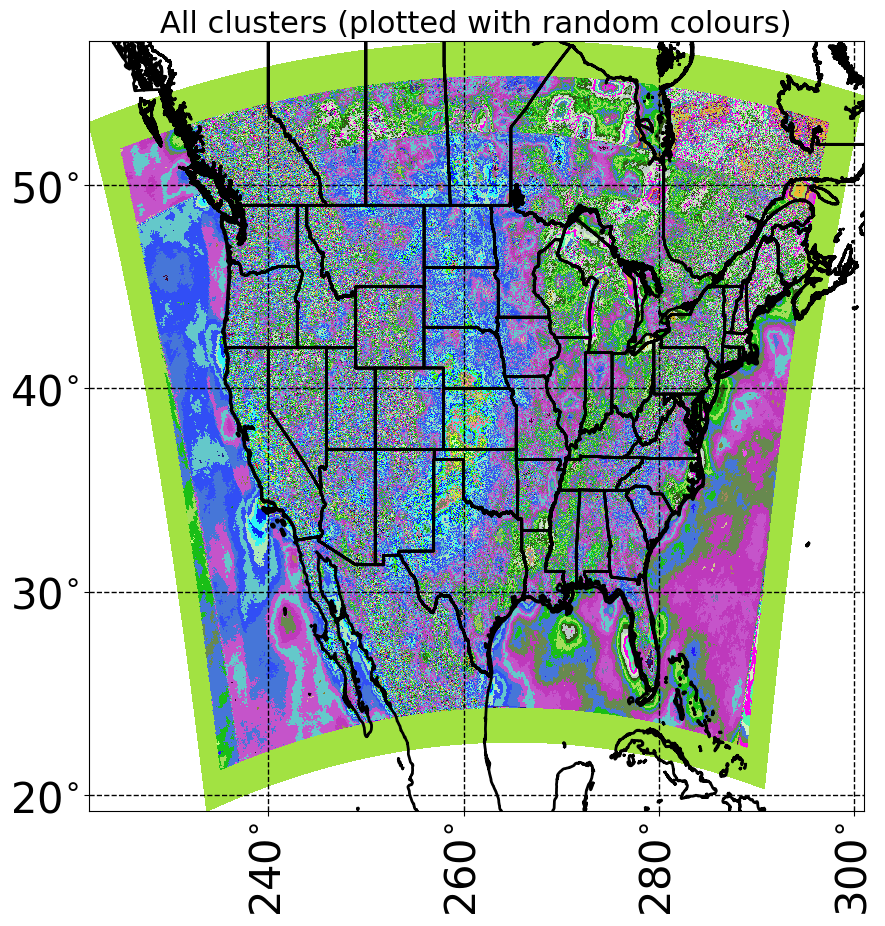

In [ ]:
%matplotlib inline

plot_all_clusters(
    cluster_id_matrix=cluster_id_matrix,
    grid_latitude_matrix_deg_n=grid_latitude_matrix_deg_n,
    grid_longitude_matrix_deg_e=grid_longitude_matrix_deg_e,
    border_latitudes_deg_n=border_latitudes_deg_n,
    border_longitudes_deg_e=border_longitudes_deg_e
)

## Plot select clusters for example 1

The next code cell plots a few select clusters -- all including some pixels in Colorado -- one at a time.  For each cluster, this code creates two figures:
 - One showing the lat/long position of every pixel in the cluster
 - One showing the histograms of temperature bias and elevation in said cluster, along with the correlation between temperature bias and elevation (reported in the title)

Each histogram figure shows the following information for one cluster:
 - Distribution of elevations in the cluster (purple bars)
 - Distribution of temperature biases in the cluster (green bars; oriented downward, instead of upward, for convenience)
 - Pearson correlation between elevation and bias (shown as a text string in the title)

Recall that Pearson correlation varies from $\left[ -1, +1 \right]$, with $-1$ indicating that the two quantities are perfectly anticorrelated and $+1$ meaning that the two quantities are perfectly correlated.  Hence, in this case, a correlation of $-1$ means that whenever elevation increases, temperature decreases -- while a correlation of $+1$ means that whenever elevation increases, temperature bias also increases.  You will see that some clusters have a weak correlation (absolute value close to $0$); in these clusters, elevation has little influence on temperature bias.  You will also see that some clusters have a strong correlation (absolute value close to $1$); in these clusters, elevation strongly controls temperature bias.

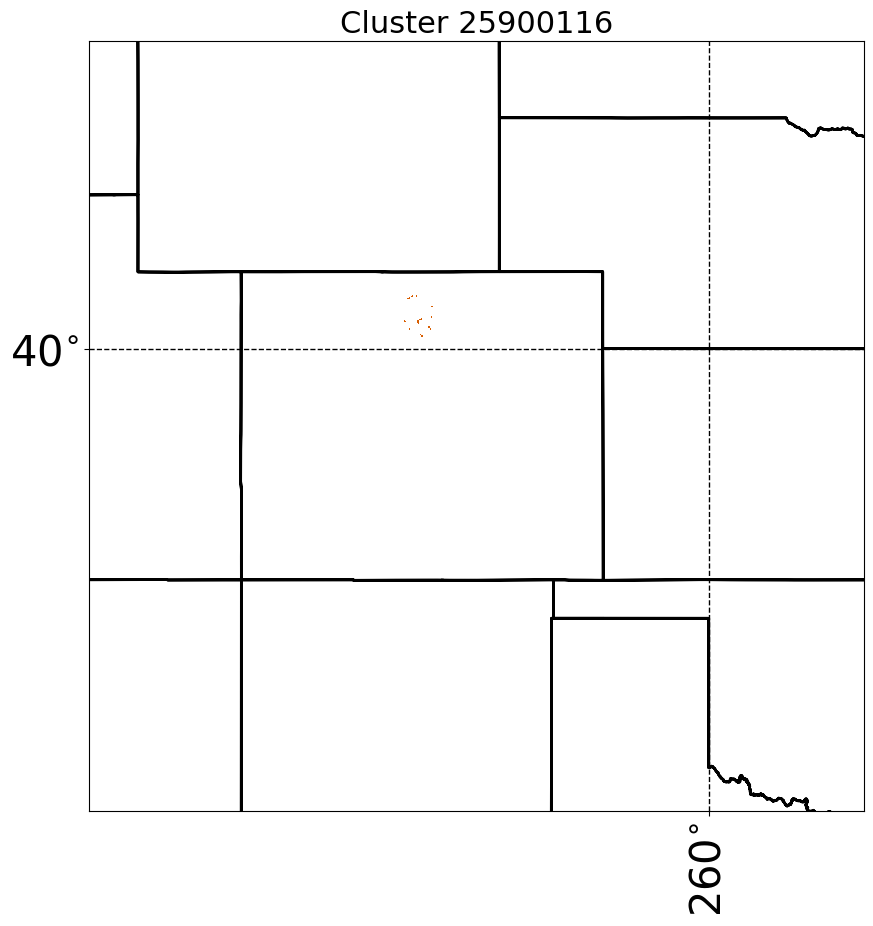

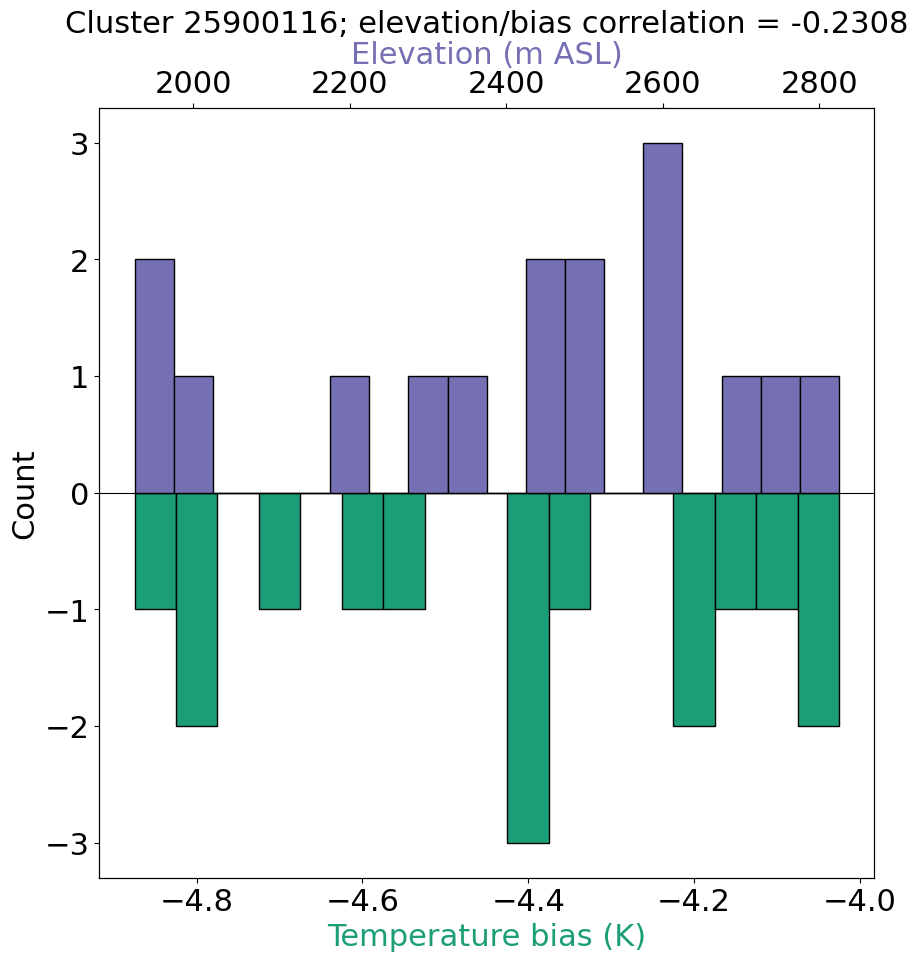

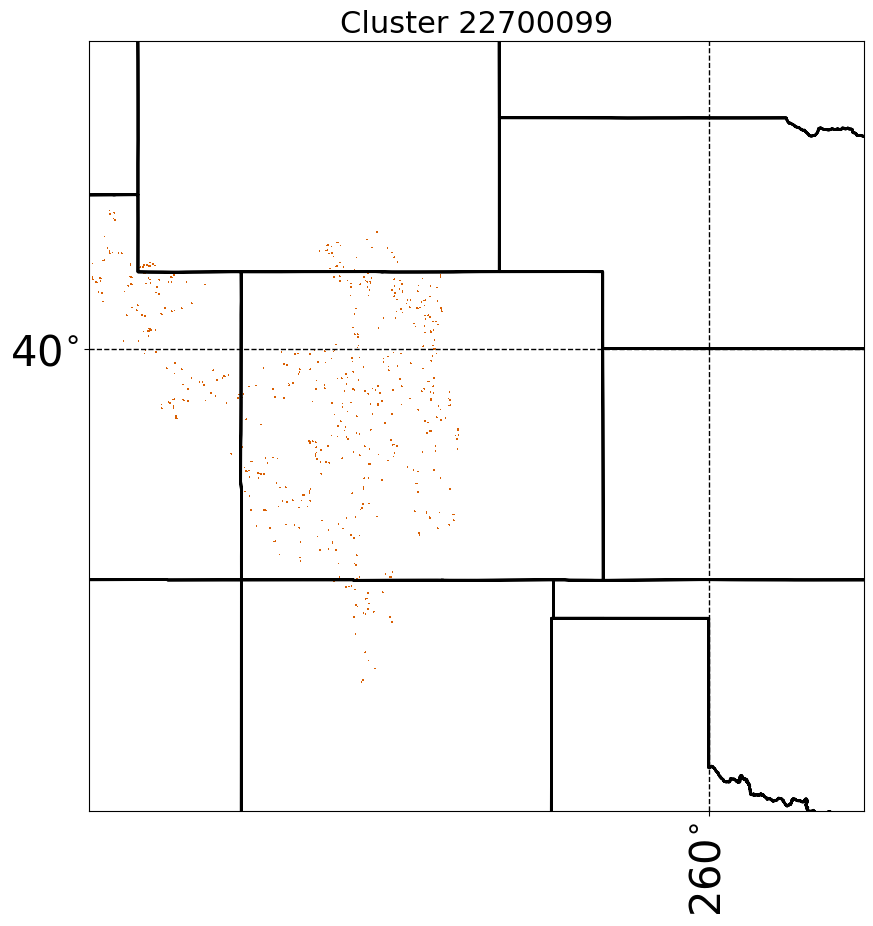

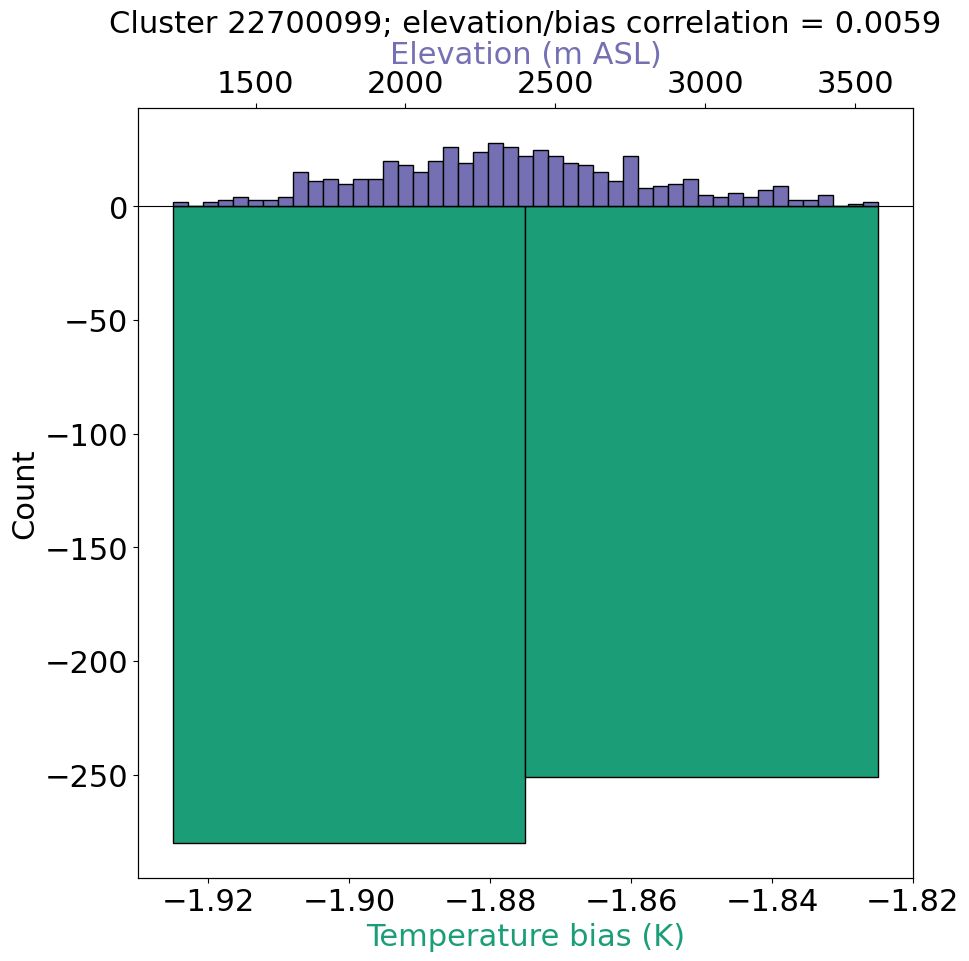

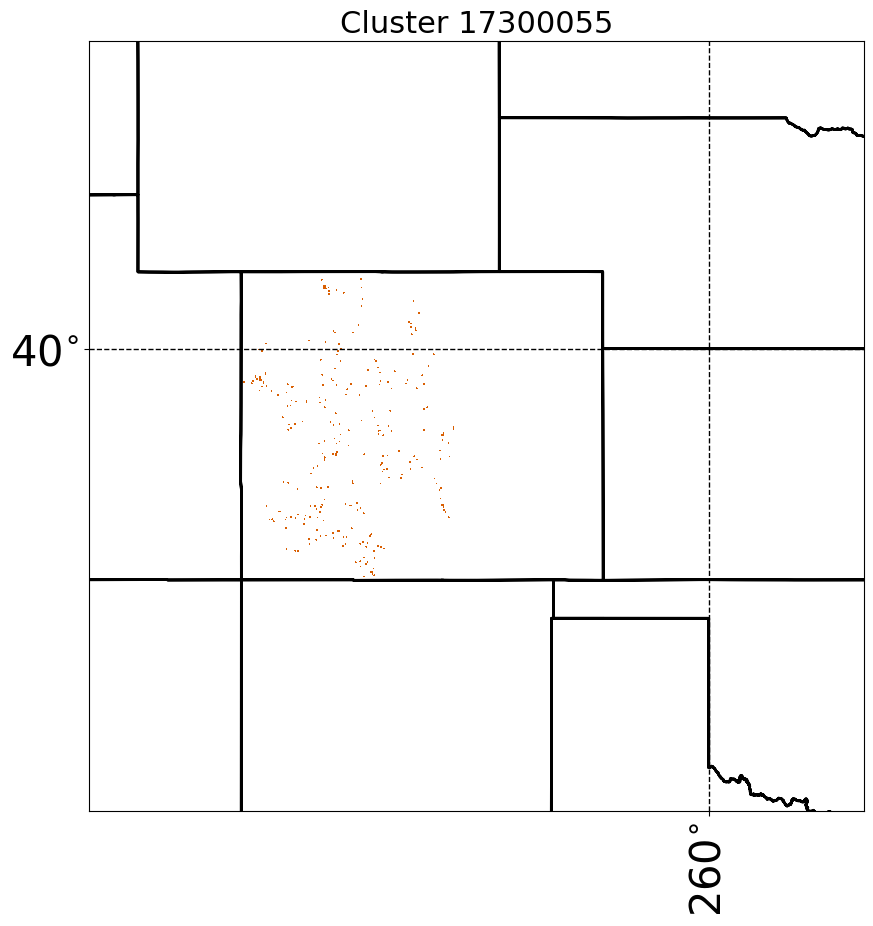

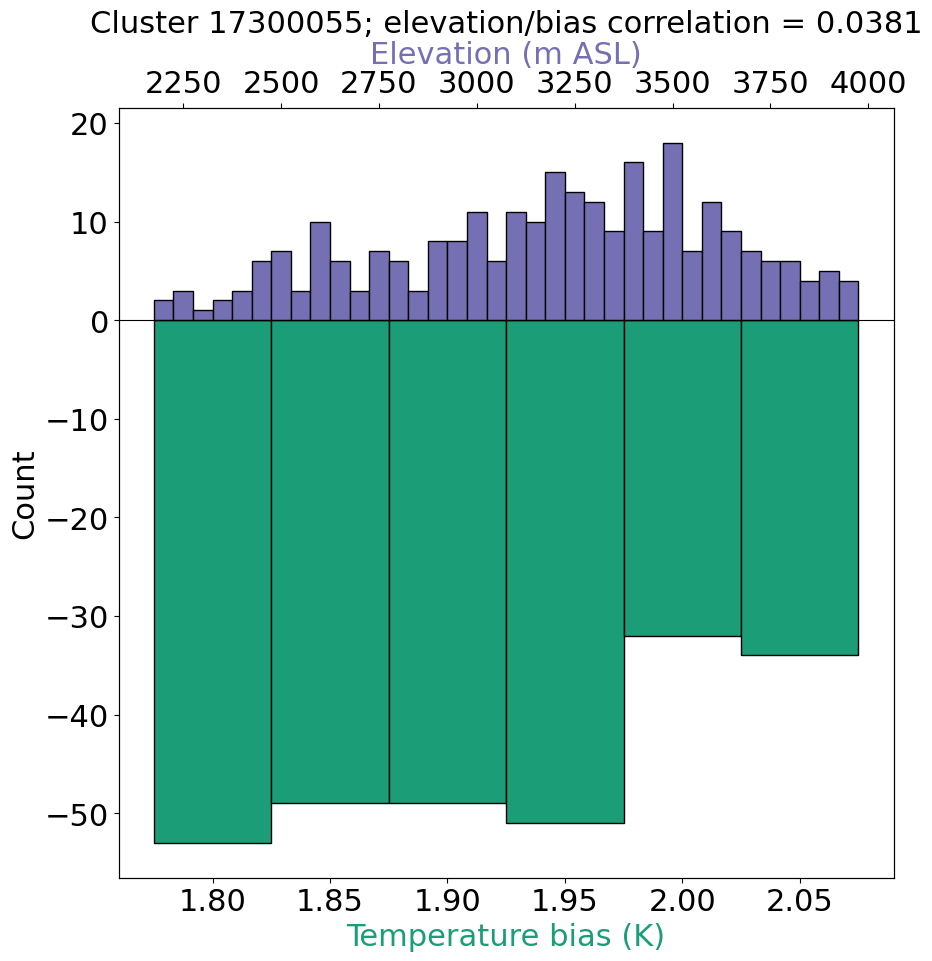

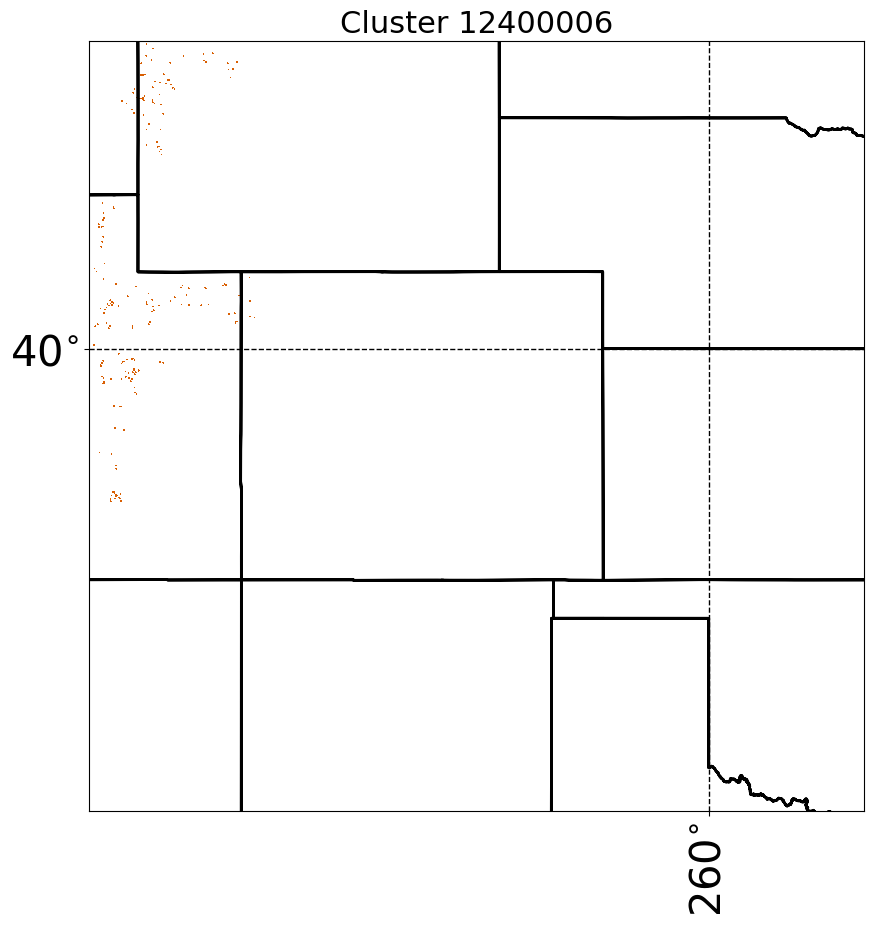

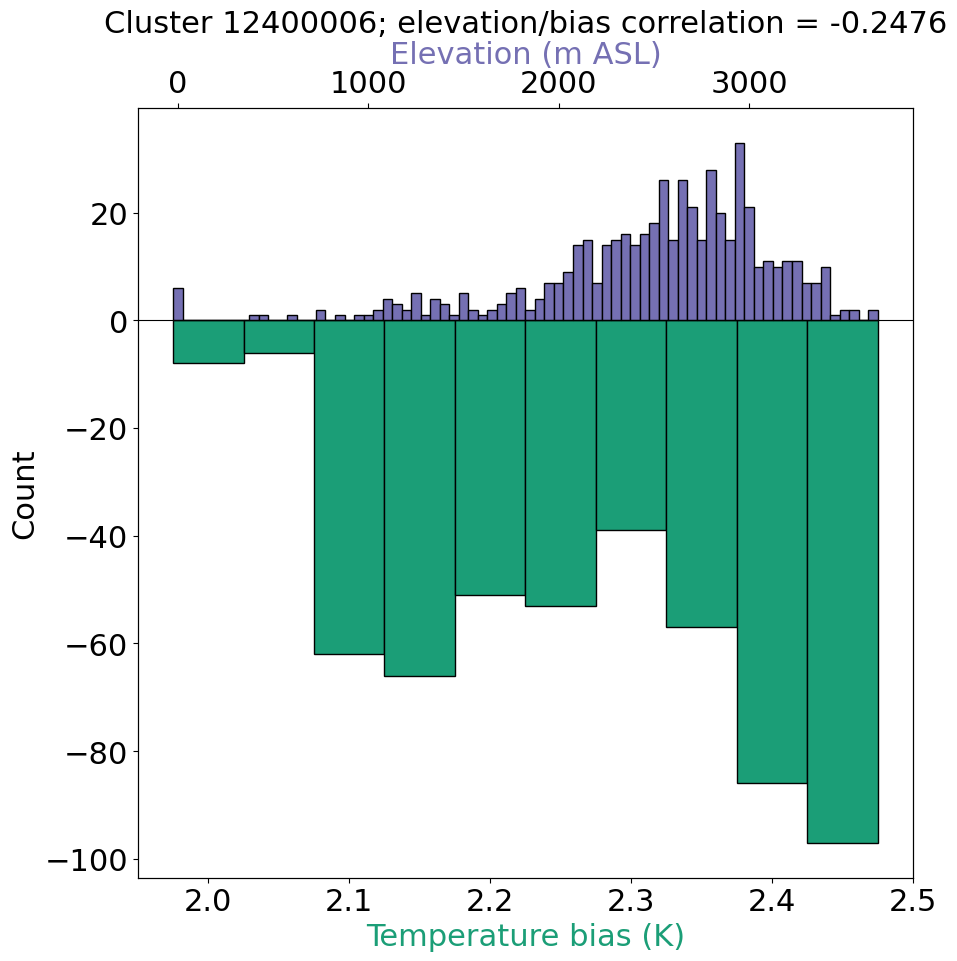

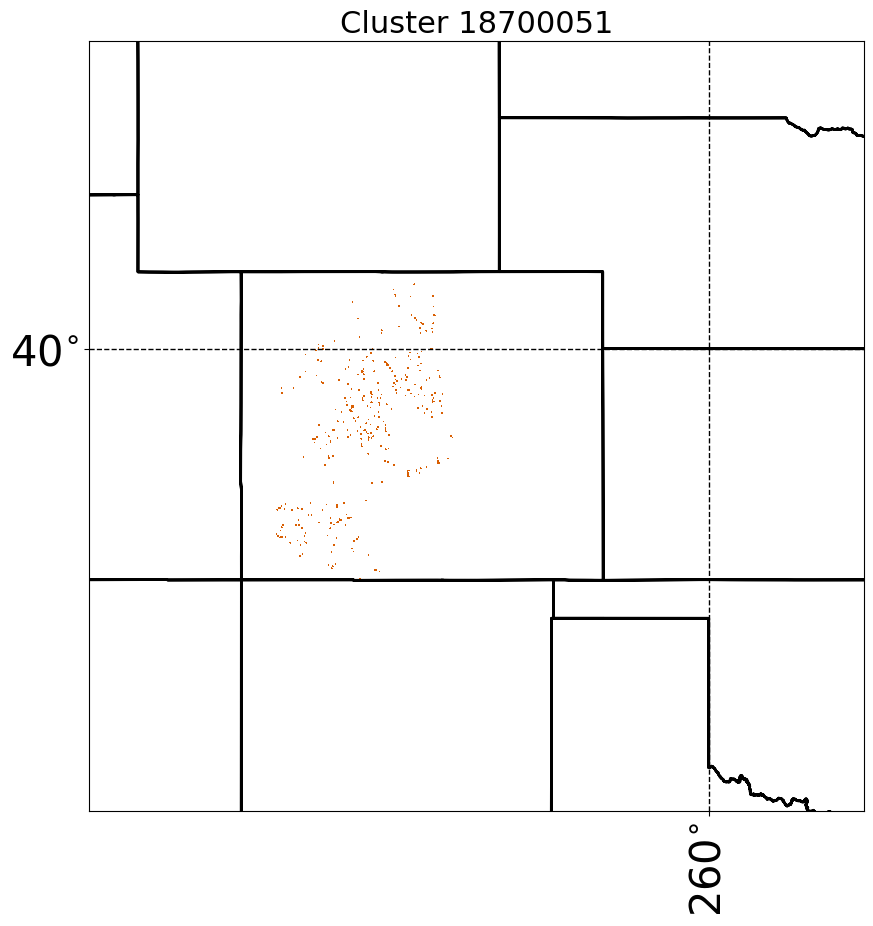

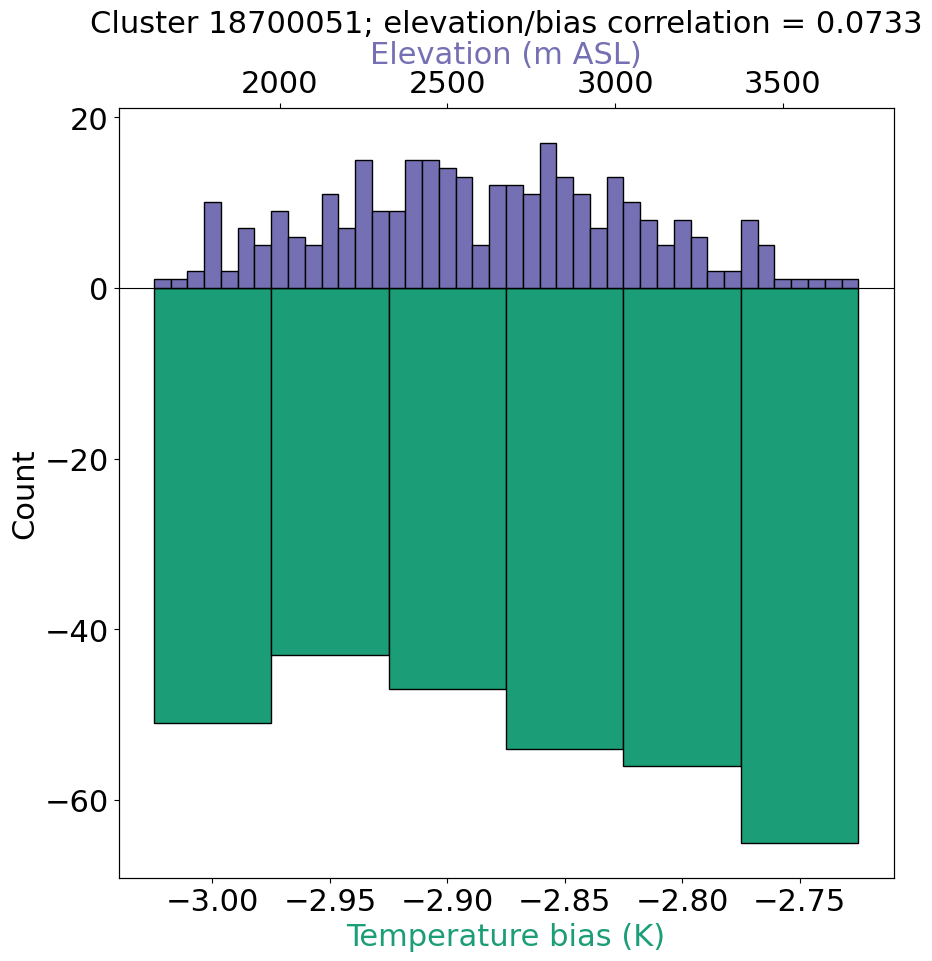

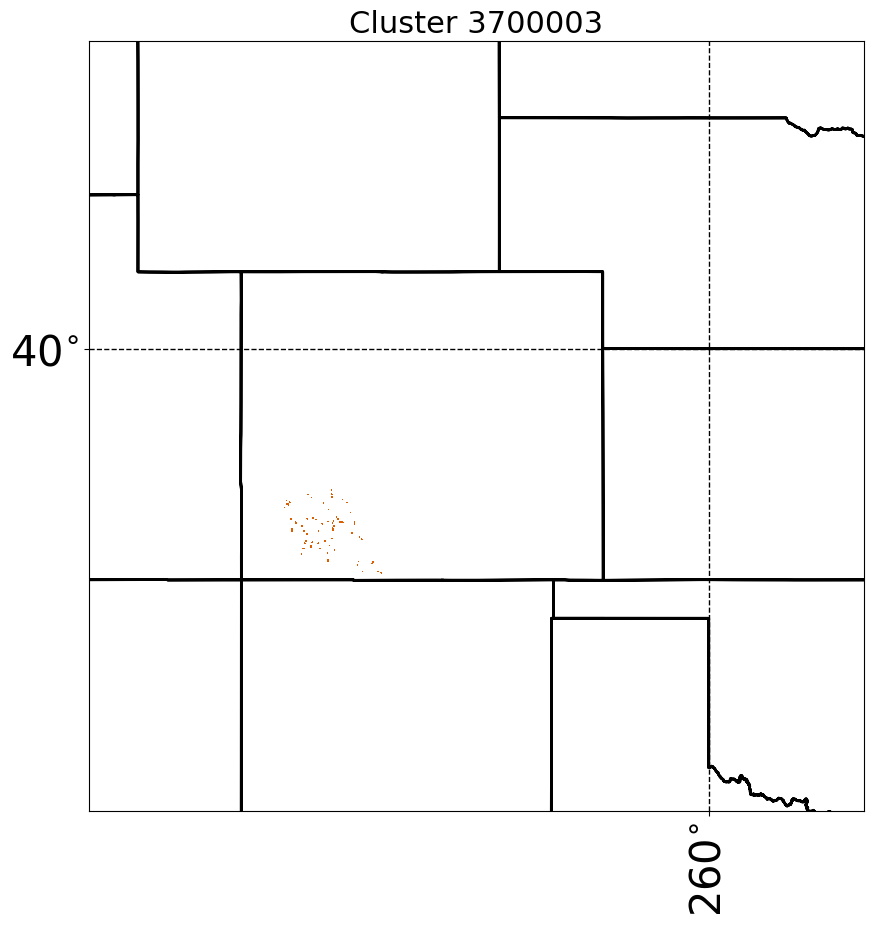

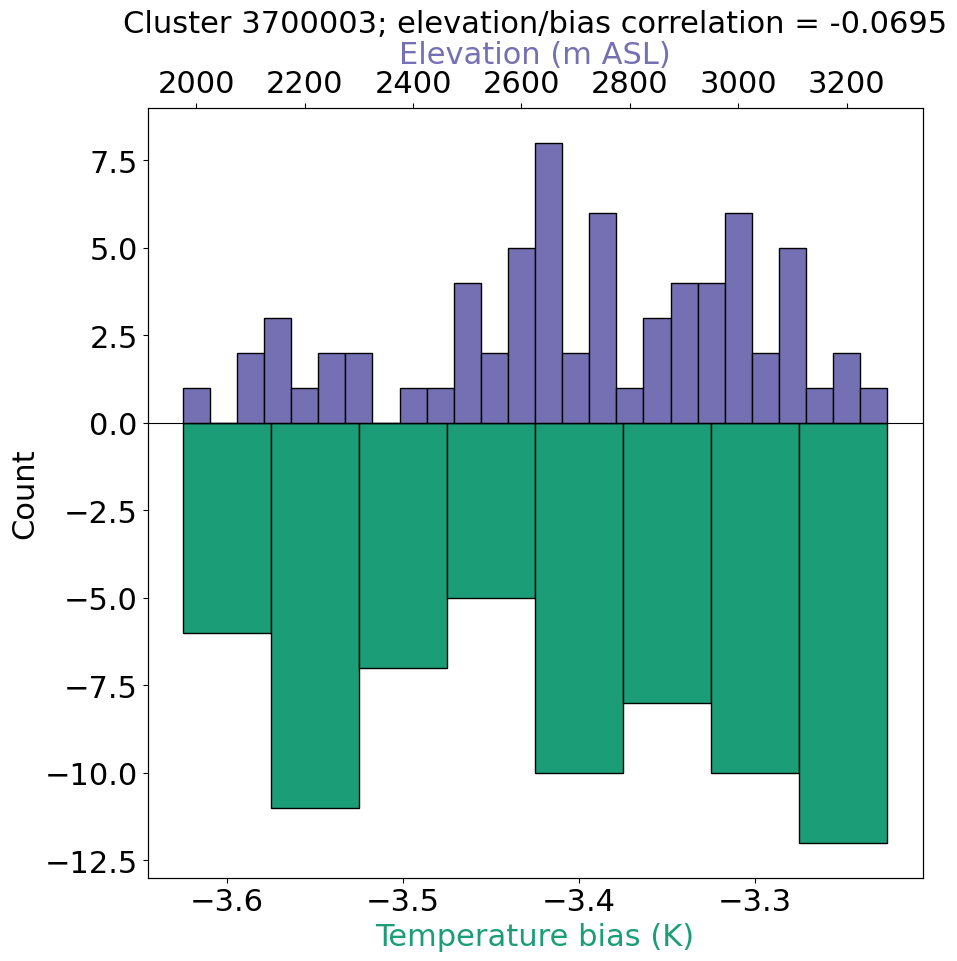

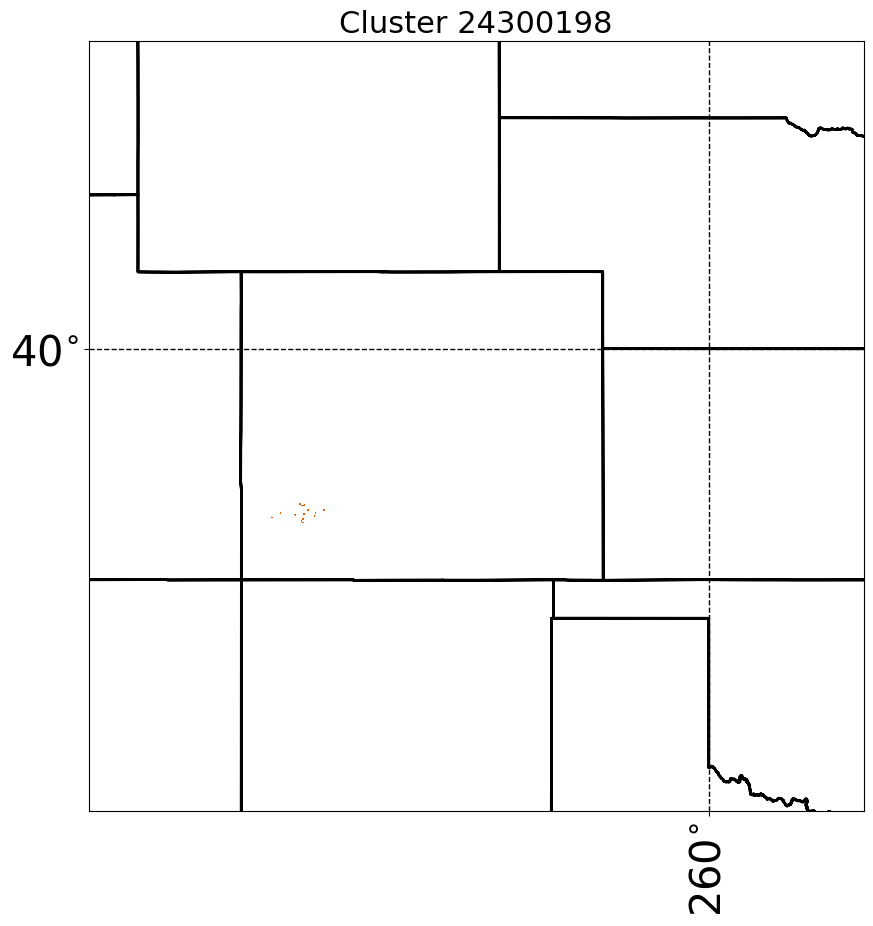

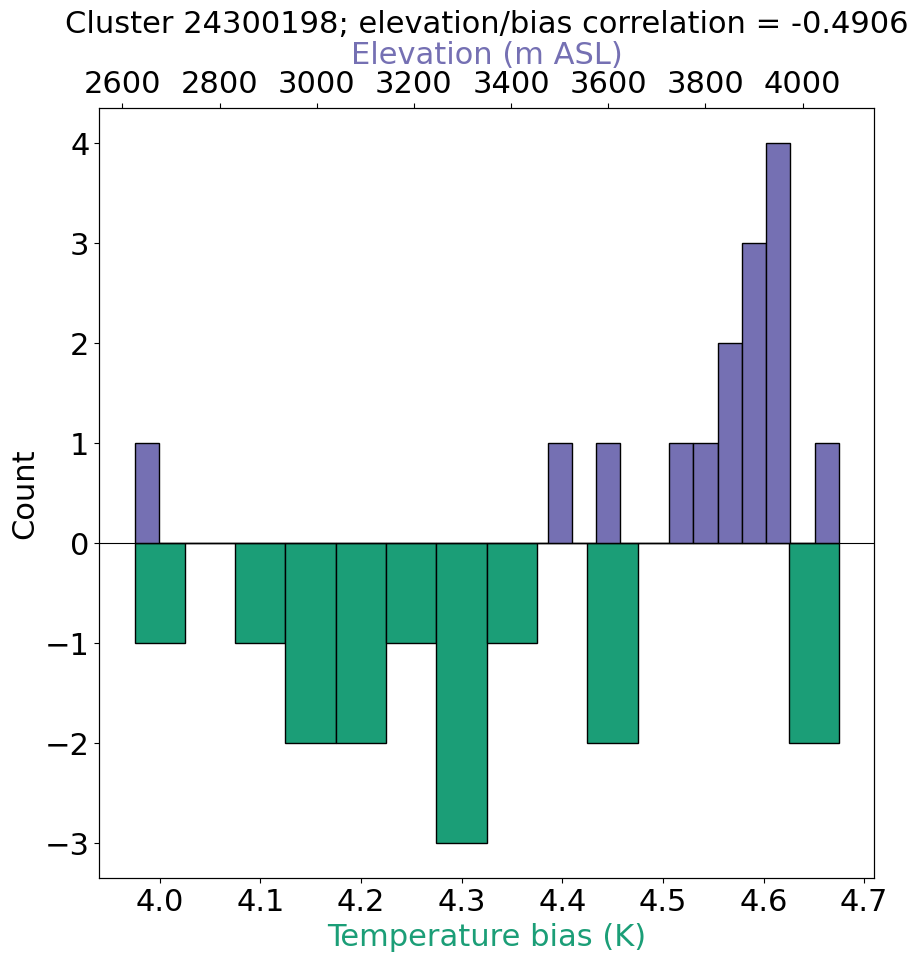

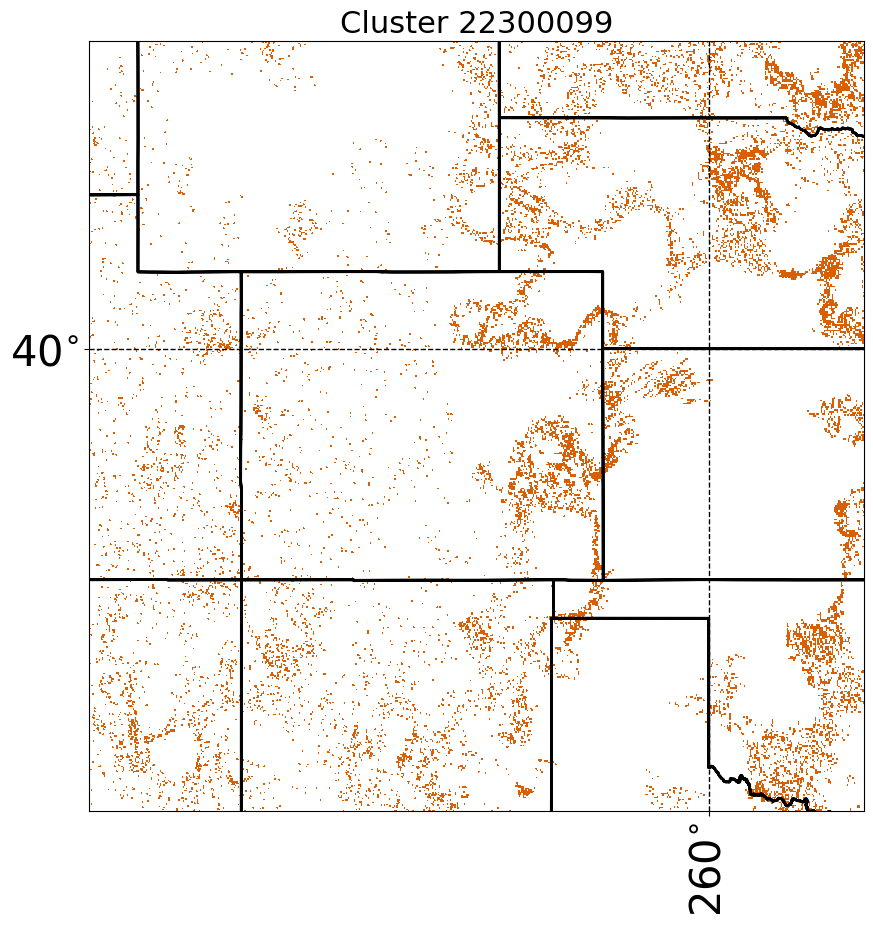

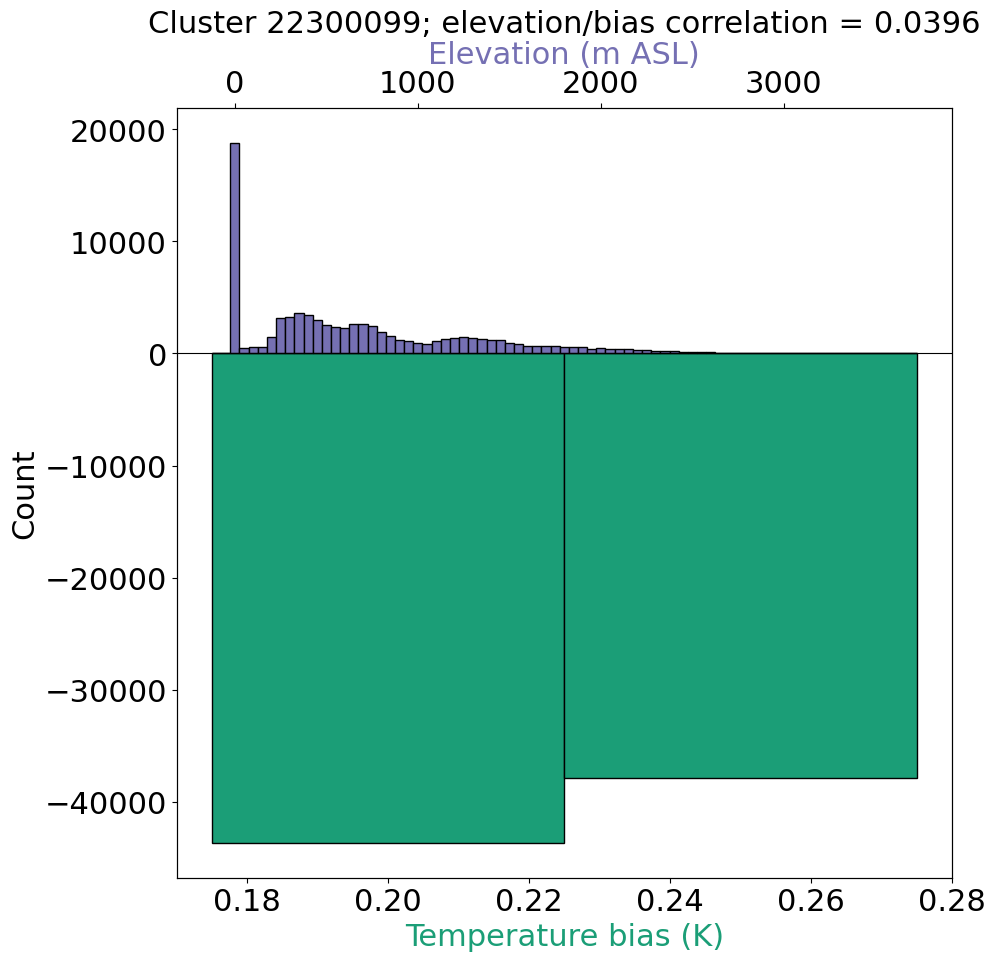

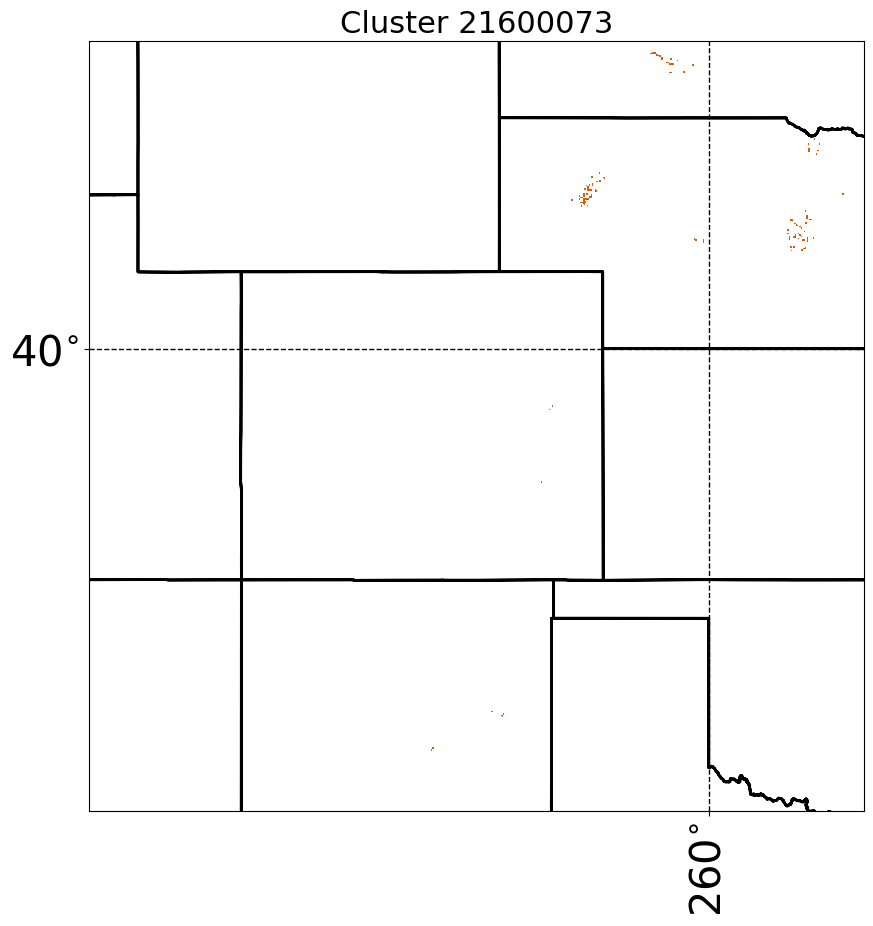

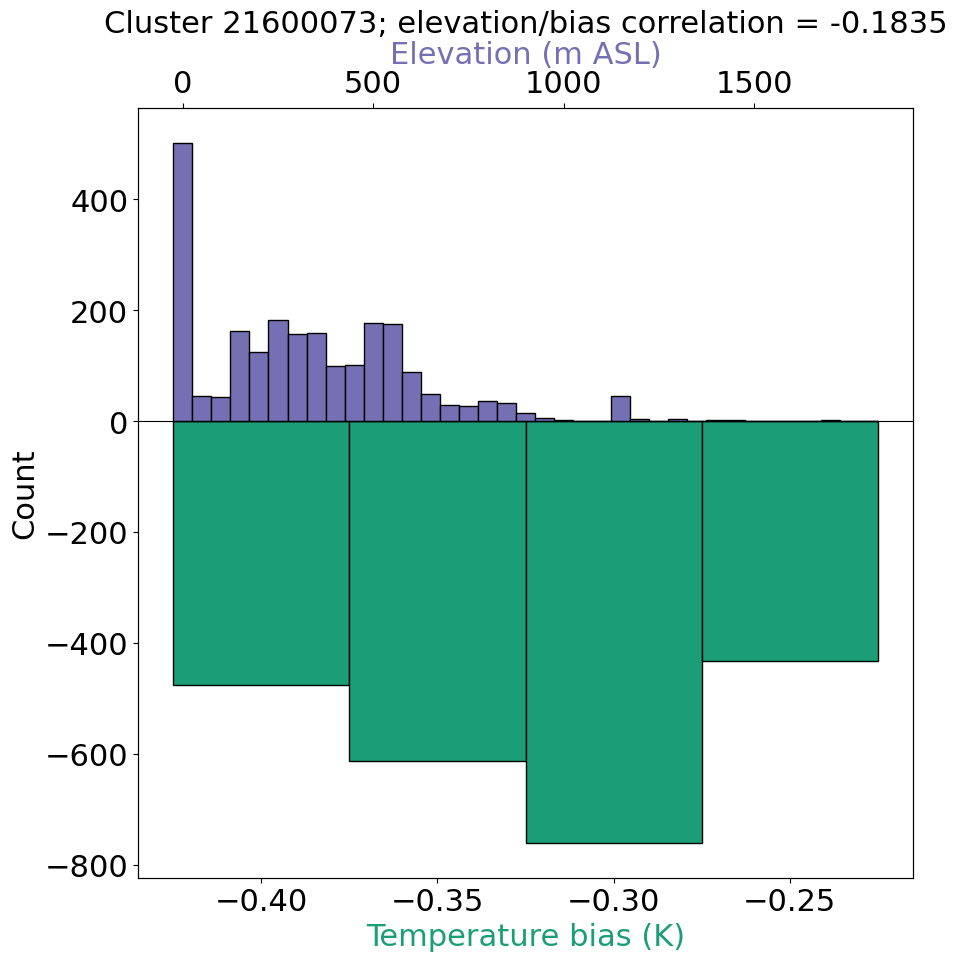

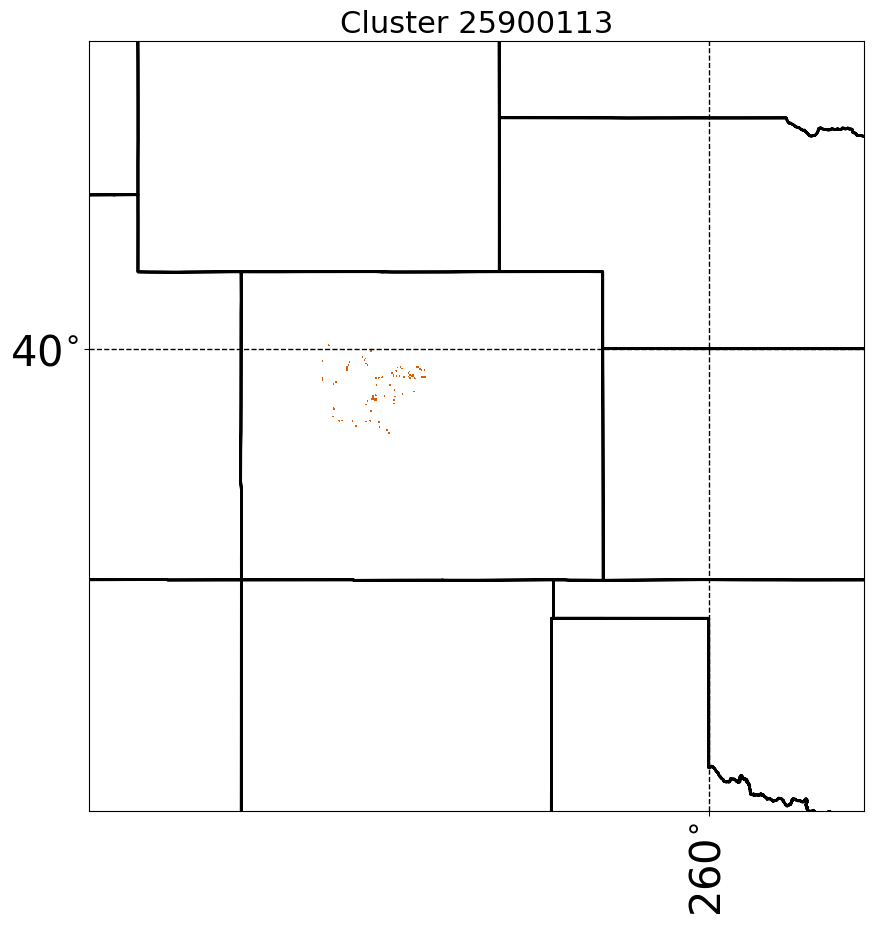

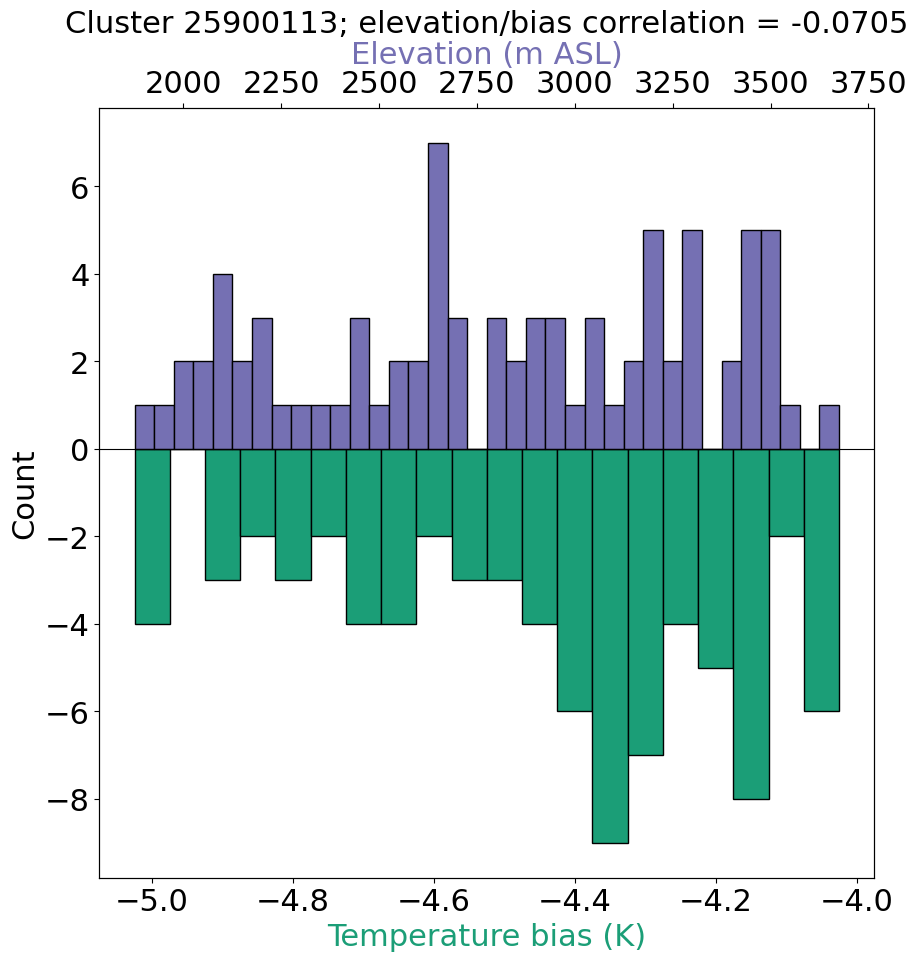

In [ ]:
%matplotlib inline

nbm_constant_file_name = (
    '/content/ml4nbm_repo/ml_for_national_blend/utils/nbm_constants.nc'
)

nbm_constant_table_xarray = nbm_constant_io.read_file(nbm_constant_file_name)
nbmct = nbm_constant_table_xarray

height_idx = numpy.where(
    nbmct.coords[nbm_constant_utils.FIELD_DIM] ==
    nbm_constant_utils.OROGRAPHIC_HEIGHT_NAME
)[0][0]
grid_elevation_matrix_m_asl = (
    nbmct[nbm_constant_utils.DATA_KEY].values[..., height_idx]
)

is_latitude_in_colorado_matrix = numpy.logical_and(
    grid_latitude_matrix_deg_n >= COLORADO_LATITUDE_LIMITS_DEG_N[0],
    grid_latitude_matrix_deg_n <= COLORADO_LATITUDE_LIMITS_DEG_N[1]
)
is_longitude_in_colorado_matrix = numpy.logical_and(
    grid_longitude_matrix_deg_e >= COLORADO_LONGITUDE_LIMITS_DEG_E[0],
    grid_longitude_matrix_deg_e <= COLORADO_LONGITUDE_LIMITS_DEG_E[1]
)
is_grid_point_in_colorado_matrix = numpy.logical_and(
    is_latitude_in_colorado_matrix, is_longitude_in_colorado_matrix
)

colorado_cluster_ids = numpy.unique(
    cluster_id_matrix[is_grid_point_in_colorado_matrix]
)
colorado_cluster_ids = colorado_cluster_ids[colorado_cluster_ids > 0]
colorado_cluster_pixel_counts = numpy.array(
    [numpy.sum(cluster_id_matrix == c) for c in colorado_cluster_ids],
    dtype=int
)

good_indices = numpy.where(colorado_cluster_pixel_counts >= 10)[0]
del colorado_cluster_pixel_counts
colorado_cluster_ids = colorado_cluster_ids[good_indices]

if len(colorado_cluster_ids) > 10:
    colorado_cluster_ids = numpy.random.choice(
        colorado_cluster_ids, size=10, replace=False
    )

for desired_cluster_id in colorado_cluster_ids:
    plot_one_cluster(
        cluster_id_matrix=cluster_id_matrix,
        desired_cluster_id=desired_cluster_id,
        grid_latitude_matrix_deg_n=grid_latitude_matrix_deg_n,
        grid_longitude_matrix_deg_e=grid_longitude_matrix_deg_e,
        border_latitudes_deg_n=border_latitudes_deg_n,
        border_longitudes_deg_e=border_longitudes_deg_e
    )
    plot_histogram_one_cluster(
        cluster_id_matrix=cluster_id_matrix,
        desired_cluster_id=desired_cluster_id,
        bias_matrix_kelvins=bias_matrix_kelvins,
        grid_elevation_matrix_m_asl=grid_elevation_matrix_m_asl
    )

# Example 2

The next code cell runs the forward clustering algorithm with the following parameters:
 - Minimum cluster size = 125 pixels
 - Bias-discretization intervals = 0.25, 0.50, 0.75, 1.00, 1.25 K
 - Buffer distance = 2 pixels

In [ ]:
forward_cluster_id_matrix = bias_clustering.find_clusters(
    bias_matrix=bias_matrix_kelvins + 0.,
    min_cluster_size_px=125,
    bias_discretization_intervals=numpy.linspace(0.25, 1.25, num=5, dtype=float),
    buffer_distance_px=2,
    do_multiprocessing=True
)

Streaming output truncated to the last 5000 lines.
Number of pixels in 46080th cluster = 7
Number of pixels in 46081th cluster = 7
Number of pixels in 46082th cluster = 7
Number of pixels in 46083th cluster = 7
Number of pixels in 46084th cluster = 7
Number of pixels in 46085th cluster = 7
Number of pixels in 46086th cluster = 7
Number of pixels in 46087th cluster = 7
Number of pixels in 46088th cluster = 7
Number of pixels in 46089th cluster = 7
Number of pixels in 46090th cluster = 7
Number of pixels in 46091th cluster = 7
Number of pixels in 46092th cluster = 7
Number of pixels in 46093th cluster = 7
Number of pixels in 46094th cluster = 7
Number of pixels in 46095th cluster = 7
Number of pixels in 46096th cluster = 7
Number of pixels in 46097th cluster = 7
Number of pixels in 46098th cluster = 7
Number of pixels in 46099th cluster = 7
Number of pixels in 46100th cluster = 7
Number of pixels in 46101th cluster = 7
Number of pixels in 46102th cluster = 7
Number of pixels in 46103th c

## Plot all clusters for example 2

The next code cell plots all clusters for this particular solution in one map.

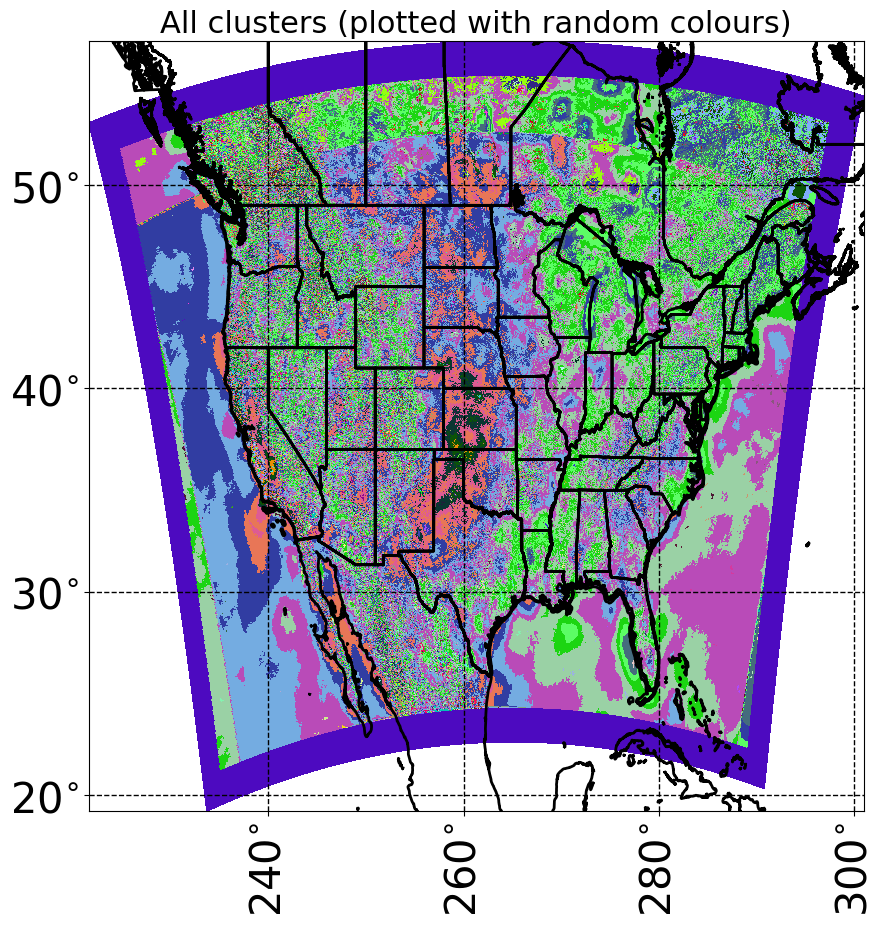

In [ ]:
%matplotlib inline

plot_all_clusters(
    cluster_id_matrix=forward_cluster_id_matrix,
    grid_latitude_matrix_deg_n=grid_latitude_matrix_deg_n,
    grid_longitude_matrix_deg_e=grid_longitude_matrix_deg_e,
    border_latitudes_deg_n=border_latitudes_deg_n,
    border_longitudes_deg_e=border_longitudes_deg_e
)

## Plot select clusters for example 2

The next code cell plots a few select clusters -- all including some pixels in Colorado -- one at a time.

In [ ]:
%matplotlib inline

nbm_constant_file_name = (
    '/content/ml4nbm_repo/ml_for_national_blend/utils/nbm_constants.nc'
)

nbm_constant_table_xarray = nbm_constant_io.read_file(nbm_constant_file_name)
nbmct = nbm_constant_table_xarray

height_idx = numpy.where(
    nbmct.coords[nbm_constant_utils.FIELD_DIM] ==
    nbm_constant_utils.OROGRAPHIC_HEIGHT_NAME
)[0][0]
grid_elevation_matrix_m_asl = (
    nbmct[nbm_constant_utils.DATA_KEY].values[..., height_idx]
)

is_latitude_in_colorado_matrix = numpy.logical_and(
    grid_latitude_matrix_deg_n >= COLORADO_LATITUDE_LIMITS_DEG_N[0],
    grid_latitude_matrix_deg_n <= COLORADO_LATITUDE_LIMITS_DEG_N[1]
)
is_longitude_in_colorado_matrix = numpy.logical_and(
    grid_longitude_matrix_deg_e >= COLORADO_LONGITUDE_LIMITS_DEG_E[0],
    grid_longitude_matrix_deg_e <= COLORADO_LONGITUDE_LIMITS_DEG_E[1]
)
is_grid_point_in_colorado_matrix = numpy.logical_and(
    is_latitude_in_colorado_matrix, is_longitude_in_colorado_matrix
)

colorado_cluster_ids = numpy.unique(
    forward_cluster_id_matrix[is_grid_point_in_colorado_matrix]
)
colorado_cluster_ids = colorado_cluster_ids[colorado_cluster_ids > 0]
colorado_cluster_pixel_counts = numpy.array(
    [numpy.sum(forward_cluster_id_matrix == c) for c in colorado_cluster_ids],
    dtype=int
)

good_indices = numpy.where(colorado_cluster_pixel_counts >= 10)[0]
del colorado_cluster_pixel_counts
colorado_cluster_ids = colorado_cluster_ids[good_indices]

if len(colorado_cluster_ids) > 10:
    colorado_cluster_ids = numpy.random.choice(
        colorado_cluster_ids, size=10, replace=False
    )

for desired_cluster_id in colorado_cluster_ids:
    plot_one_cluster(
        cluster_id_matrix=forward_cluster_id_matrix,
        desired_cluster_id=desired_cluster_id,
        grid_latitude_matrix_deg_n=grid_latitude_matrix_deg_n,
        grid_longitude_matrix_deg_e=grid_longitude_matrix_deg_e,
        border_latitudes_deg_n=border_latitudes_deg_n,
        border_longitudes_deg_e=border_longitudes_deg_e
    )
    plot_histogram_one_cluster(
        cluster_id_matrix=forward_cluster_id_matrix,
        desired_cluster_id=desired_cluster_id,
        bias_matrix_kelvins=bias_matrix_kelvins,
        grid_elevation_matrix_m_asl=grid_elevation_matrix_m_asl
    )

# How to select tunable parameters

The ultimate purpose of this spatial clustering is bias correction, with one bias-correction model applied to every cluster.  Thus, my current choice of tunable parameters is based on the performance of the bias-correction models that I trained later, with one set of bias-correction models for each clustering solution.  I tried all 160 combinations of the following parameter values:
 - Minimum cluster size = $\lbrace$10, 25, 50, 100, 250$\rbrace$ px
 - Buffer distances = $\lbrace$0, 2, 4, 6$\rbrace$ px
 - Algorithm types = $\lbrace$forward, backwards$\rbrace$
 - Bias-discretization intervals = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0) K **or**<br />(0.075, 0.150, 0.225, 0.300, 0.375, 0.450, 0.525, 0.600, 0.675, 0.750, 0.825, 0.900, 0.975) K **or**<br />(0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00) K **or**<br />(0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200, 0.225, 0.250, 0.275, 0.300, 0.325, 0.350, 0.375, 0.400, 0.425, 0.450, 0.475, 0.500, 0.525, 0.550, 0.575, 0.600, 0.625, 0.650, 0.675, 0.700, 0.725, 0.750, 0.775, 0.800, 0.825, 0.850, 0.875, 0.900, 0.925, 0.950, 0.975, 1.000) K
<br /><br />

I also tried all 150 combinations of the following parameter values:
 - Minimum cluster size = $\lbrace$100, 250, 350, 500, 750, 1000$\rbrace$ px
 - Buffer distances = $\lbrace$6, 9, 12, 15, 20$\rbrace$ px
 - Algorithm types = backwards only
 - Bias-discretization intervals = (0.3, 0.6, 0.9, 1.2) K **or**<br />(0.25, 0.50, 0.75, 1.00) K **or**<br />(0.15, 0.30, 0.45, 0.60, 0.75, 0.90, 1.05) K **or**<br />(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0) K
<br /><br />

The best parameters -- *i.e.*, those leading to the most skillful bias correction, based on many evaluation metrics computed on independent validation data (from separate years than the data used for training the neural network or bias-correction models) -- were as follows:
 - Minimum cluster size = 250 px
 - Buffer distance = 6 px
 - Algorithm type = backwards
 - Bias-discretization intervals = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0) K